# Fashion (Text & Img)

## 1. Early Fusion

In [ ]:
import numpy as np
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import torch
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import sys
from pathlib import Path

def proj_root(marker="src"):
    p = Path.cwd().resolve()
    for parent in [p] + list(p.parents):
        if (parent / marker).exists():
            return parent
    raise RuntimeError("no root found")

PROJECT_ROOT = proj_root()
sys.path.insert(0, str(PROJECT_ROOT))

from src.comparative.utils.paths import ROOT, DATA_PROCESSED, CHECKPOINTS

print(PROJECT_ROOT)
print(ROOT)
print(DATA_PROCESSED)
print(CHECKPOINTS)

D:\COmparative_Study_of_Multimodal_Represenations
D:\COmparative_Study_of_Multimodal_Represenations\src
D:\COmparative_Study_of_Multimodal_Represenations\src\data\processed
D:\COmparative_Study_of_Multimodal_Represenations\src\src\comparative\checkpoints


In [15]:
# test data
TEST_CSV = DATA_PROCESSED / "fashion" / "test.csv"
TEST_IMG_EMB = DATA_PROCESSED / "fashion" / "test_image_emb.npy"

# model checkpoint
MODEL_PATH = (
    CHECKPOINTS / "default" / "fashion_classical_early" / "last.ckpt"
)

print("Project root :", ROOT)
print("Test CSV     :", TEST_CSV)
print("Image emb    :", TEST_IMG_EMB)
print("Model ckpt   :", MODEL_PATH)

# TEST_CSV = "D:/COmparative_Study_of_Multimodal_Represenations/data/processed/fashion/test.csv"
# TEST_IMG_EMB = "D:/COmparative_Study_of_Multimodal_Represenations/data/processed/fashion/test_image_emb.npy"
# MODEL_PATH = "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashion_classical_early/last.ckpt" 


Project root : D:\COmparative_Study_of_Multimodal_Represenations\src
Test CSV     : D:\COmparative_Study_of_Multimodal_Represenations\src\data\processed\fashion\test.csv
Image emb    : D:\COmparative_Study_of_Multimodal_Represenations\src\data\processed\fashion\test_image_emb.npy
Model ckpt   : D:\COmparative_Study_of_Multimodal_Represenations\src\src\comparative\checkpoints\default\fashion_classical_early\last.ckpt


In [ ]:

test_df = pd.read_csv(TEST_CSV)
image_embeddings = np.load(TEST_IMG_EMB)

# label encoder on the fly
labels = test_df['label'].values
unique_labels = sorted(set(labels))
label2idx = {label: idx for idx, label in enumerate(unique_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

labels_encoded = np.array([label2idx[label] for label in labels])

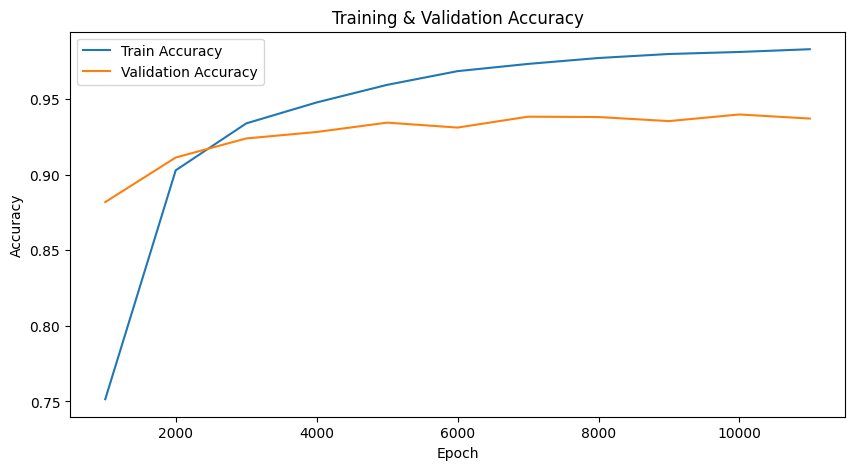

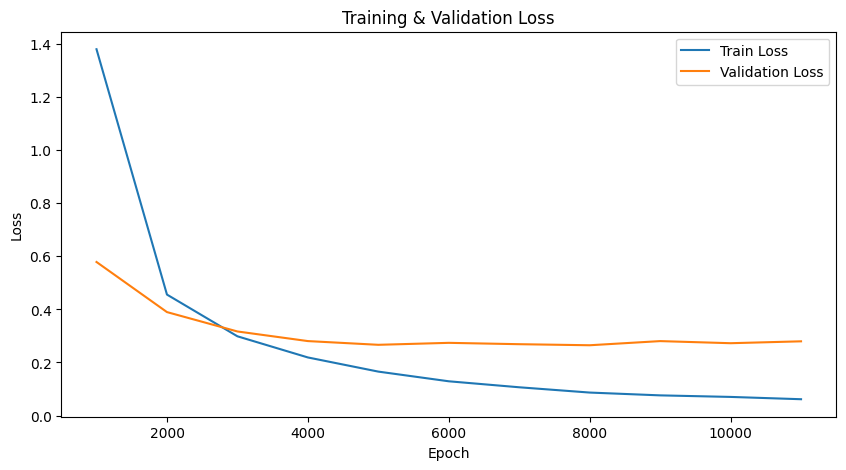

In [ ]:
# metrics visualization

EVENTS_PATH = CHECKPOINTS / "lightning_logs" / "fashion_classical_early" / "version_0" / "events.out.tfevents.1751974434"
event_acc = EventAccumulator(EVENTS_PATH)
event_acc.Reload()

# extracting epoch-wise metrics
val_accuracies = event_acc.Scalars('val_acc')
train_accuracies = event_acc.Scalars('train_acc_epoch')
val_losses = event_acc.Scalars('val_loss')
train_losses = event_acc.Scalars('train_loss_epoch')

# converting to df
val_acc_df = pd.DataFrame(val_accuracies)
train_acc_df = pd.DataFrame(train_accuracies)
val_loss_df = pd.DataFrame(val_losses)
train_loss_df = pd.DataFrame(train_losses)

# accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(train_acc_df['step'], train_acc_df['value'], label='Train Accuracy')
plt.plot(val_acc_df['step'], val_acc_df['value'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()

# loss plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df['step'], train_loss_df['value'], label='Train Loss')
plt.plot(val_loss_df['step'], val_loss_df['value'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

Accuracy:
* Rapid Initial Learning: training acc increases quickly during initial epochs, showing that model efficiently learns from training data;
* Val acc increases with training acc but levels off eventually, meaning that model stops improving on unseen data;
* This gap between training and val acc is evidence of mild OVERFITTING -> model continues to improve on train data, but it doesn't transfer to new samples (unseen).

Loss: 
* Training loss declines sharply and continues to drop, indicating the model's increasing fit to the training set;
* Val loss decreases at first but then stabilizes -> mild overfitting;
* This gap between losses is moderate/stable, w/o signs of instability -> no severe overfitting.


In [ ]:
MODEL_PATH = CHECKPOINTS / "default" / "fashion_classical_early" / "last.ckpt"
import sys
# sys.path.append("D:/COmparative_Study_of_Multimodal_Represenations/src")
from comparative.models.classical.early_fusion import EarlyFusionClassifier # model

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = EarlyFusionClassifier.load_from_checkpoint(MODEL_PATH)
model.to(DEVICE)
model.eval()

texts = test_df['description'].fillna("").astype(str).tolist()
img_embs = image_embeddings  # [num_samples, 512]
BATCH_SIZE = 64

y_pred = []
logits_all = []

for start in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch_texts = texts[start:start+BATCH_SIZE]
    batch_imgs = img_embs[start:start+BATCH_SIZE]
    # Tokenize text
    enc = tokenizer(
        batch_texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    batch = {k: v.to(DEVICE) for k, v in enc.items()}
    batch['image_emb'] = torch.tensor(batch_imgs).float().to(DEVICE)

    with torch.no_grad():
        logits = model(batch)
    batch_preds = logits.argmax(dim=1).cpu().numpy()
    y_pred.extend(batch_preds)
    logits_all.append(logits.cpu().numpy())

y_pred = np.array(y_pred)
logits_all = np.concatenate(logits_all, axis=0)  # shape: [N, n_classes]
# y_true is already available as labels_encoded

print("Inference done! y_pred shape:", y_pred.shape)

C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 56/56 [02:56<00:00,  3.15s/it]

Inference done! y_pred shape: (3555,)


In [ ]:
# unified label mapping
all_labels = [label for label, idx in sorted(label2idx.items(), key=lambda x: x[1])]
idx2label = {idx: label for label, idx in enumerate(all_labels)}
n_classes = len(all_labels)

Accuracy: 0.0203
Precision: 0.0205
Recall: 0.0203
F1 Score: 0.0204


,precision,recall,f1-score,support
Accessory Gift Set,1.000000,1.000000,1.000000,8.0
Baby Dolls,0.000000,0.000000,0.000000,1.0
Backpacks,0.964286,0.947368,0.955752,57.0
Bangle,1.000000,1.000000,1.000000,7.0
Basketballs,1.000000,1.000000,1.000000,1.0
...,...,...,...,...
Water Bottle,0.000000,0.000000,0.000000,1.0
Wristbands,0.000000,0.000000,0.000000,1.0
micro avg,0.029617,0.020253,0.024056,3555.0
macro avg,0.042430,0.042285,0.042357,3555.0


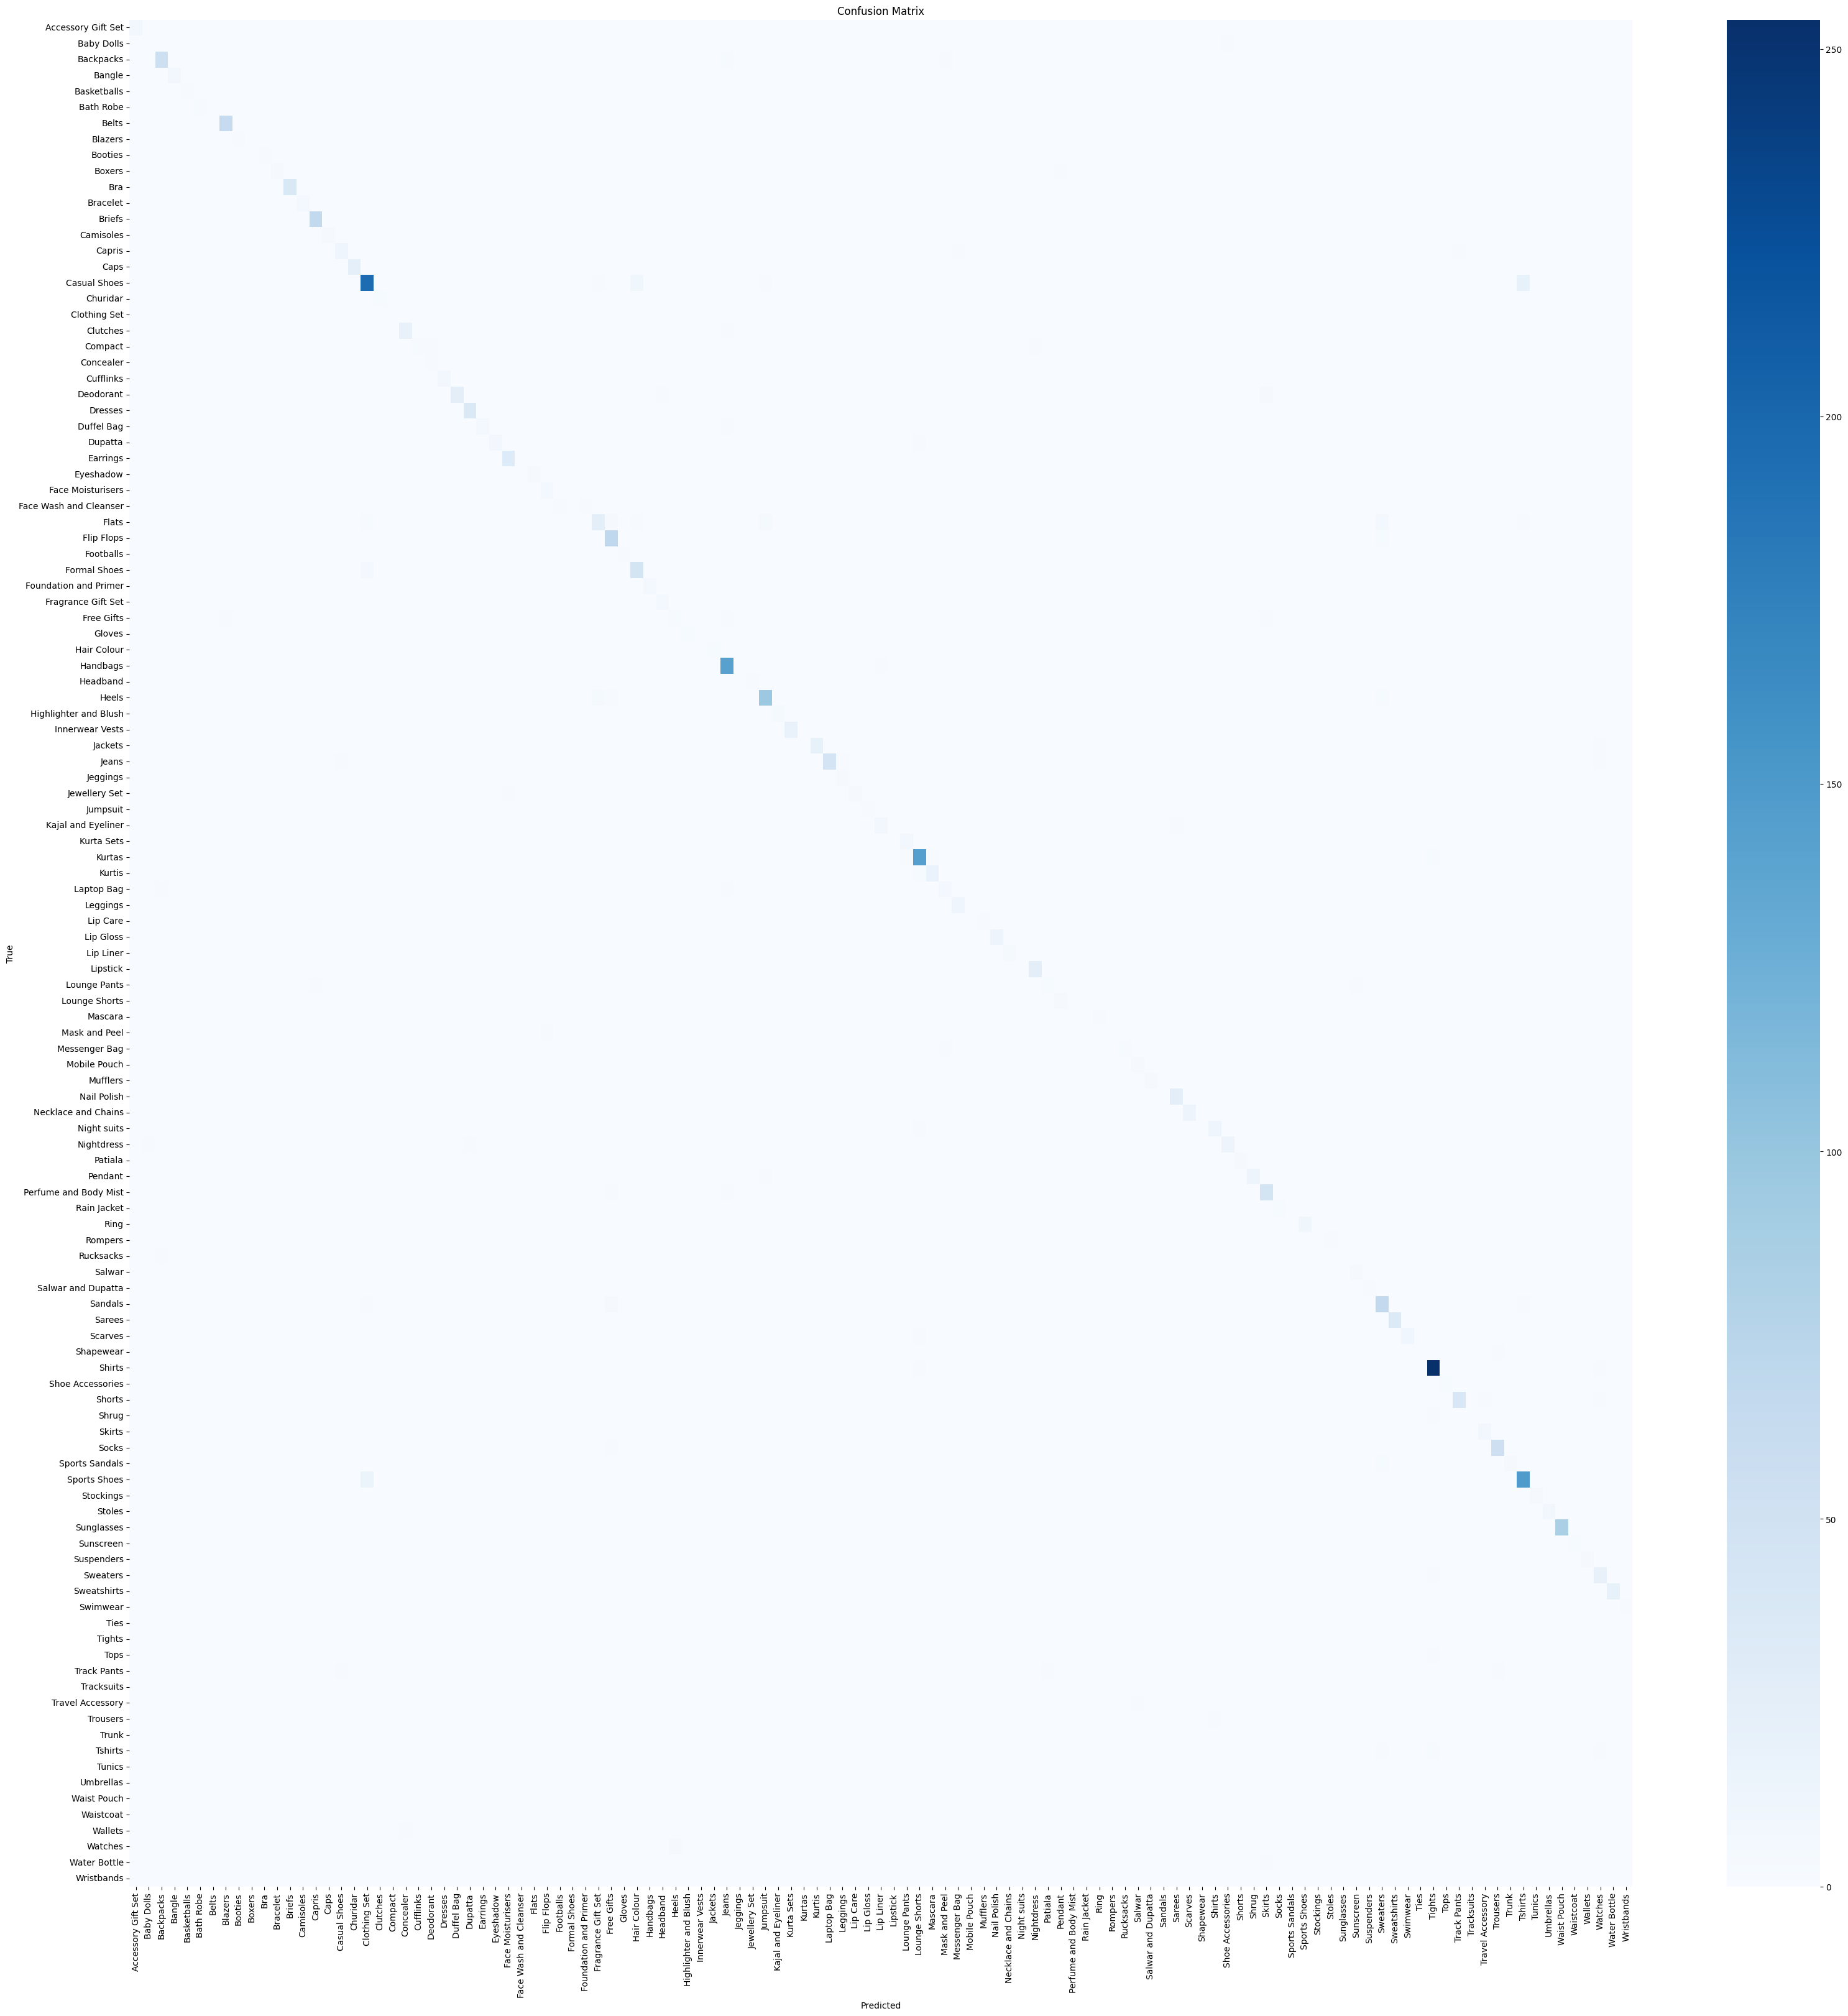

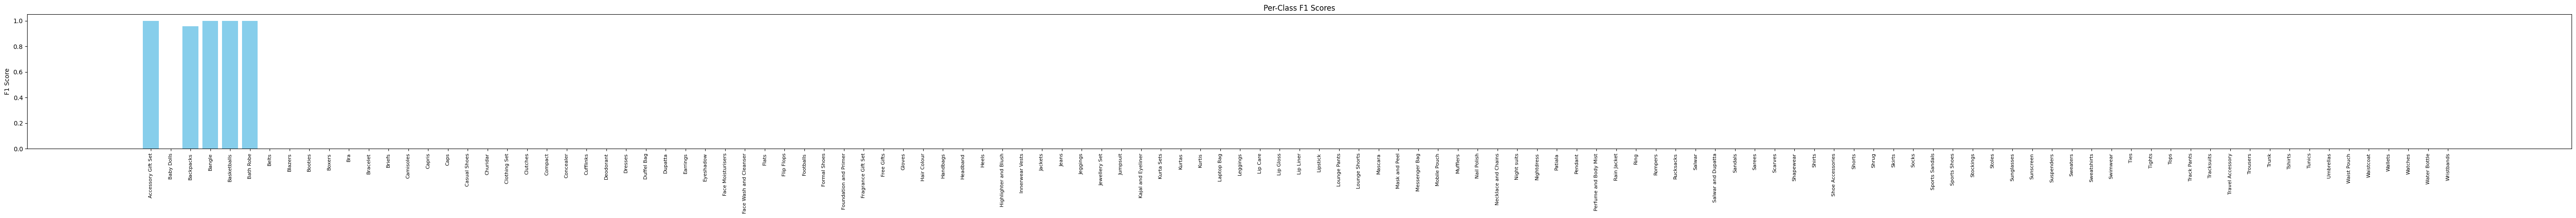

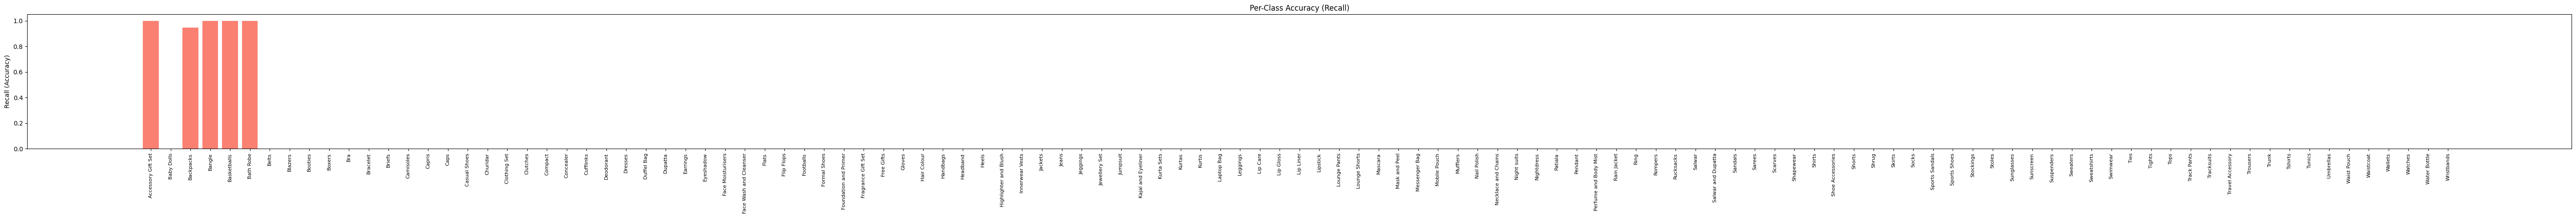

In [ ]:
# eval

# 1. Metrics
acc = accuracy_score(labels_encoded, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(labels_encoded, y_pred, average='weighted', zero_division=0)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 2. Per-class metrics table (includes all possible classes)
class_report = classification_report(
    labels_encoded, y_pred,
    labels=list(range(n_classes)),
    target_names=all_labels,
    output_dict=True,
    zero_division=0  # Prevents errors if a class is missing in predictions
)
df_report = pd.DataFrame(class_report).transpose()
display(df_report)

# 3. Confusion matrix (all classes, 0 for those not present in test)
cm = confusion_matrix(labels_encoded, y_pred, labels=list(range(n_classes)))
plt.figure(figsize=(max(10, n_classes // 3), max(8, n_classes // 3)))
sns.heatmap(cm, annot=False, xticklabels=all_labels, yticklabels=all_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 4. Per-class F1 barplot (0 for classes not in test)
f1_scores = [class_report[cls]['f1-score'] if cls in class_report else 0 for cls in all_labels]
plt.figure(figsize=(max(16, n_classes // 2), 5))
plt.bar(all_labels, f1_scores, color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores")
plt.tight_layout()
plt.show()

# 5. Per-class Recall barplot
recalls = [class_report[cls]['recall'] if cls in class_report else 0 for cls in all_labels]
plt.figure(figsize=(max(16, n_classes // 2), 5))
plt.bar(all_labels, recalls, color='salmon')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Recall (Accuracy)")
plt.title("Per-Class Accuracy (Recall)")
plt.tight_layout()
plt.show()

* From confusion matrix we see that correct predictions are highly concentrated in a tiny number of classes, most classes have almost no true positive (TP) predictions. Almost all predictions fall along the diagonal for a few classes, with most of the matrix being empty (i.e., no predictions for most classes);
* Per-class F1/Recall: here only some classes (e.g., "Accessory Gift Set," "Backpacks," "Bangle," "Basketballs") achieve perfect/near-perfect F1 scores, while majority of classes show 0 precision, recall, and F1;
* Severe class imbalance or model bias: model appears to be heavily biased toward a very small subset of classes, predicting almost all test instances as belonging to those few. This results in perfect/near-perfect F1 scores for those classes, but 0 for the majority of others;
* Overall scores (e.g., accuracy) are very low (~2%) which is barely above random chance for 120+ classes. The weighted and macro averages confirm the model isn't generalizing to the test set.

Possible reasons is severe overfitting - model may have overfit to a samll subset of training data, or model could've collapsed to always predicting the majority class

* F1 and recall plots show that only a few classes are being predicted at all, and the rest are ignored by the model.

Conclusion: early fusion isn't able to generalize across diverse product categories, highlighting critical issues with class imbalance, label mapping, or training stability. Addressing these issues is a crucial next step before further multimodal benchmarking.

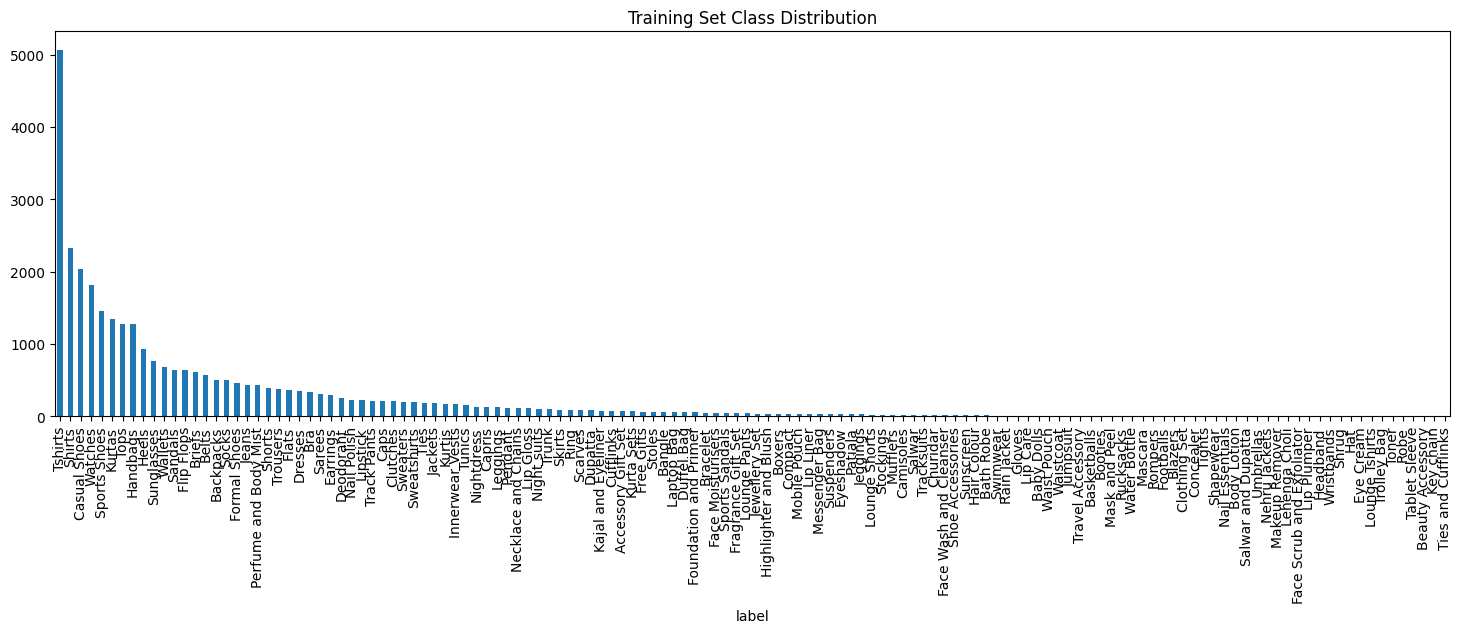

In [ ]:
import matplotlib.pyplot as plt
train_labels = pd.read_csv(DATA_PROCESSED / "fashion" / "train.csv")['label']

train_label_counts = train_labels.value_counts()
plt.figure(figsize=(18,5))
train_label_counts.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Training Set Class Distribution')
plt.show()

Training set class imbalance is a critical challenge. We see from distribution plot above that some classes dominate (tshirts, shirts, casual shoes), while others have very low number of samples (<100)

* Model bias: DL models tend to overfit to frequent classes, ignoring rare ones.
* Performance collapse: model, trained with standard cross-entropy, is stimulated to maximize accuracy by predicting the majority classes. It explains why only a small handful of classes appear in predictions, with most classes never predicted at all.

Conclusion: class imbalance is the root cause of model's poor multiclass performance and prediction collapse. Thus, addressing imbalance is crucial for any meaningful evaluation or model improvement.

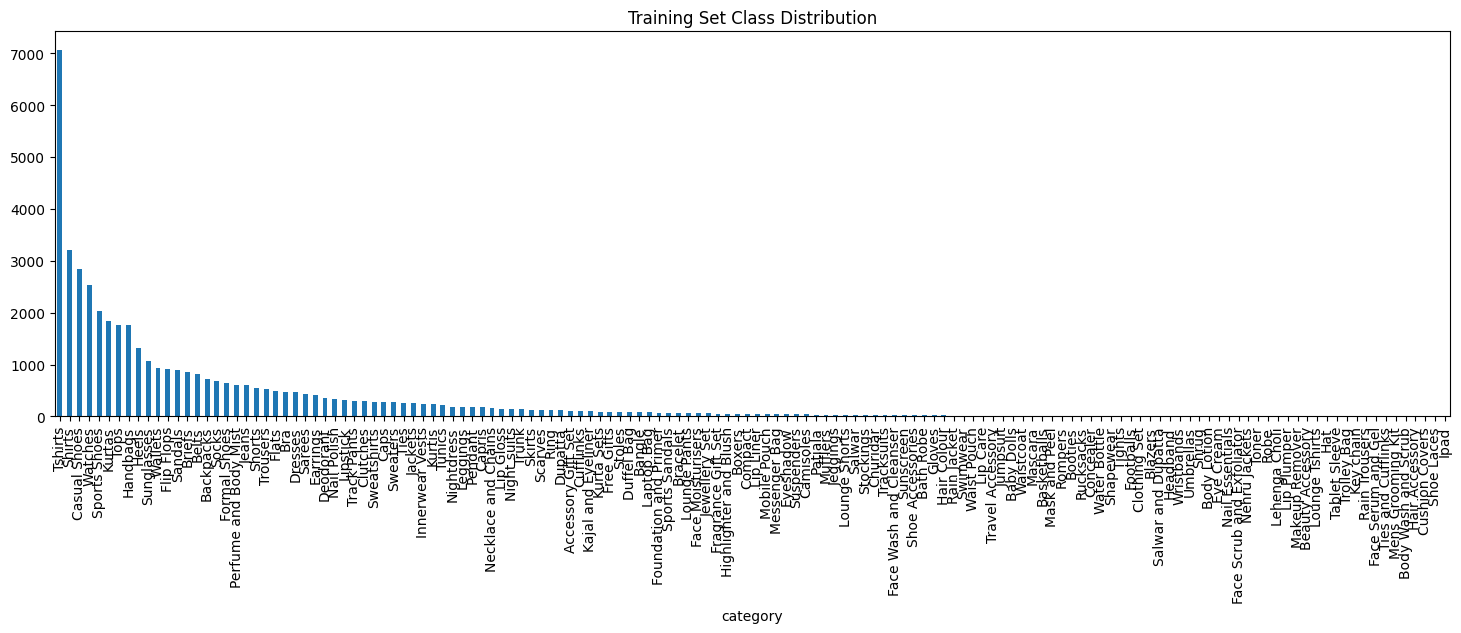

In [ ]:
from src.comparative.utils.paths import ROOT, DATA_RAW
train_labels = pd.read_csv(DATA_RAW / "fashion" / "data.csv")['category']
# train_labels = pd.read_csv('D:/COmparative_Study_of_Multimodal_Represenations/data/raw/fashion/data.csv')['category']
train_label_counts = train_labels.value_counts()
plt.figure(figsize=(18,5))
train_label_counts.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Training Set Class Distribution')
plt.show()

# confirming inbalance in both processed and raw data

Class rebalancing, loss weighting, or data augmentation are required for credible benchmarking. Evaluation must report macro metrics, per-class recall, and confusion matrix, highlighting the head and tail performance gap.
Future experiments should explore:
* Class-weighted/focal loss
* Oversampling rare classes
* Balanced mini-batches
* Zero-shot or few-shot learning approaches

#### Analysis for head & tail classes (test result)

In [ ]:
from sklearn.metrics import classification_report

# train class frequencies
train_df = pd.read_csv(DATA_PROCESSED / "fashion" / "train.csv")
# train_df = pd.read_csv('D:/COmparative_Study_of_Multimodal_Represenations/data/processed/fashion/train.csv')
class_counts = train_df['label'].value_counts()

# head and tail classes
HEAD_N = 10
head_classes = list(class_counts.index[:HEAD_N])
tail_classes = list(class_counts.index[HEAD_N:])

# map class names to indices 
head_indices = [label2idx[c] for c in head_classes if c in label2idx]
tail_indices = [label2idx[c] for c in tail_classes if c in label2idx]

# eval metrics for head and tail classes using y_true (labels_encoded) and y_pred
def filter_results(labels, preds, indices):
    mask = np.isin(labels, indices)
    return labels[mask], preds[mask]

# head metrics
y_true_head, y_pred_head = filter_results(labels_encoded, y_pred, head_indices)
report_head = classification_report(
    y_true_head, y_pred_head,
    labels=head_indices,
    target_names=[idx2label[i] for i in head_indices],
    zero_division=0,
    output_dict=True
)
df_head = pd.DataFrame(report_head).transpose()

# tail metrics
y_true_tail, y_pred_tail = filter_results(labels_encoded, y_pred, tail_indices)
report_tail = classification_report(
    y_true_tail, y_pred_tail,
    labels=tail_indices,
    target_names=[idx2label[i] for i in tail_indices],
    zero_division=0,
    output_dict=True
)
df_tail = pd.DataFrame(report_tail).transpose()

print("Head class metrics (top {} classes):".format(HEAD_N))
display(df_head)

print("Tail class metrics (remaining {} classes):".format(len(tail_indices)))
display(df_tail)

Head class metrics (top 10 classes):


,precision,recall,f1-score,support
Tshirts,0.0,0.0,0.0,563.0
Shirts,0.0,0.0,0.0,259.0
Casual Shoes,0.0,0.0,0.0,227.0
Watches,0.0,0.0,0.0,203.0
Sports Shoes,0.0,0.0,0.0,163.0
Kurtas,0.0,0.0,0.0,149.0
Tops,0.0,0.0,0.0,142.0
Handbags,0.0,0.0,0.0,142.0
Heels,0.0,0.0,0.0,104.0
Sunglasses,0.0,0.0,0.0,85.0


Tail class metrics (remaining 107 classes):


,precision,recall,f1-score,support
Wallets,0.000000,0.000000,0.000000,75.0
Sandals,0.000000,0.000000,0.000000,71.0
Flip Flops,0.000000,0.000000,0.000000,71.0
Briefs,0.000000,0.000000,0.000000,68.0
Belts,0.000000,0.000000,0.000000,64.0
...,...,...,...,...
Wristbands,0.000000,0.000000,0.000000,1.0
Shrug,0.000000,0.000000,0.000000,1.0
micro avg,0.058632,0.047431,0.052440,1518.0
macro avg,0.046395,0.046237,0.046315,1518.0


* Head classes (10): model completely fails to identify even the most common classes in the test set under current training conditions.
* Tail Classes (107): all per-class F1, precision, and recall values are also essentially zero -> model fails to generalize to rare categories as well.

Model collapse: due to severe class imbalance in training data, model is unable to make any correct predictions for neither head nor tail classes in the test set.

Conclusion: early fusion, trained on a highly imbalanced dataset without class rebalancing, is unable to generalize to any significant portion of the Fashion test set. 

### Latent Space & Cluster Analysis

In [ ]:
# computing embeddings
# from tqdm.auto import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64

texts = test_df['description'].fillna("").astype(str).tolist()
img_embs = image_embeddings  # shape: [num_samples, 512]

all_embeddings = []
y_pred = []

for start in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch_texts = texts[start:start+BATCH_SIZE]
    batch_imgs = img_embs[start:start+BATCH_SIZE]
    # Tokenize
    enc = tokenizer(
        batch_texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    batch = {k: v.to(DEVICE) for k, v in enc.items()}
    batch['image_emb'] = torch.tensor(batch_imgs).float().to(DEVICE)
    with torch.no_grad():
        # MANUAL FUSION PIPELINE (extract final fused features before head/classifier)
        x = []
        input_ids = batch.get('input_ids', None)
        attn_mask = batch.get('attention_mask', None)
        if input_ids is not None and attn_mask is not None:
            bert_out = model.encoder(input_ids=input_ids, attention_mask=attn_mask)
            pooled = bert_out.last_hidden_state[:, 0, :]
            x.append(pooled)
        if 'image_emb' in batch and batch['image_emb'] is not None:
            x.append(batch['image_emb'])
        fused = torch.cat(x, dim=1)
        fused = model.dropout(fused)
        fused_vec = torch.relu(model.fusion(fused))  # [batch_size, fusion_hidden]
        logits = model.head(fused_vec)               # [batch_size, n_classes]
        all_embeddings.append(fused_vec.cpu().numpy())
        batch_preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(batch_preds)

embeddings_test = np.concatenate(all_embeddings, axis=0)  # [N, fusion_hidden]
y_pred = np.array(y_pred)

In [ ]:
print("embeddings_test shape:", embeddings_test.shape)

embeddings_test shape: (3555, 256)


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


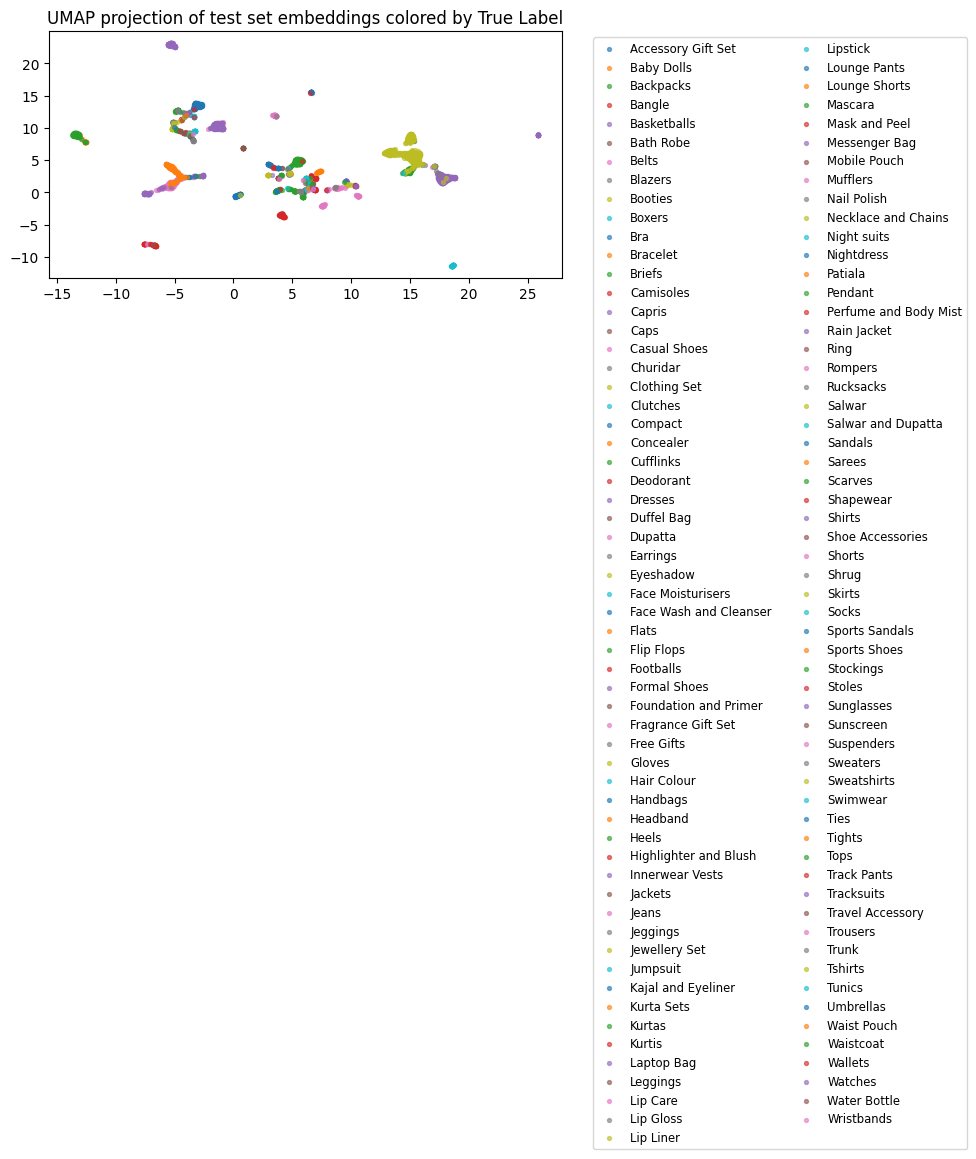

In [ ]:
# umap projection and scatter plot
import umap
# UMAP projection
umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings_test)

# by true label
plt.figure(figsize=(10,8))
for label in np.unique(labels_encoded):
    mask = labels_encoded == label
    plt.scatter(umap_proj[mask,0], umap_proj[mask,1], s=8, label=idx2label[label], alpha=0.6)
plt.title("UMAP projection of test set embeddings colored by True Label")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

UMAP Visualization: Each point corresponds to one product instance, and colors represent the true product categories. 

In the Early Fusion model, most classes appear highly mixed,
forming small groups with notable overlap between colors. Only a few "head" categories form
compact clusters, which implies that the model has learned consistent representations for those
dominant classes but not for the rare ones. 
* Some classes form coherent clusters, indicating that model can distinguish them at the representation level;
* Some overlapping clusters: many points are scattered, most classes are highly mixed -> poor semantic separation 

Conclusion: model's joint latent space does encode some information about major categories (some semantic structure is captured), but representation collapse and overlap for rare classes reveal the effect of data imbalance (poor separation of rare classes).

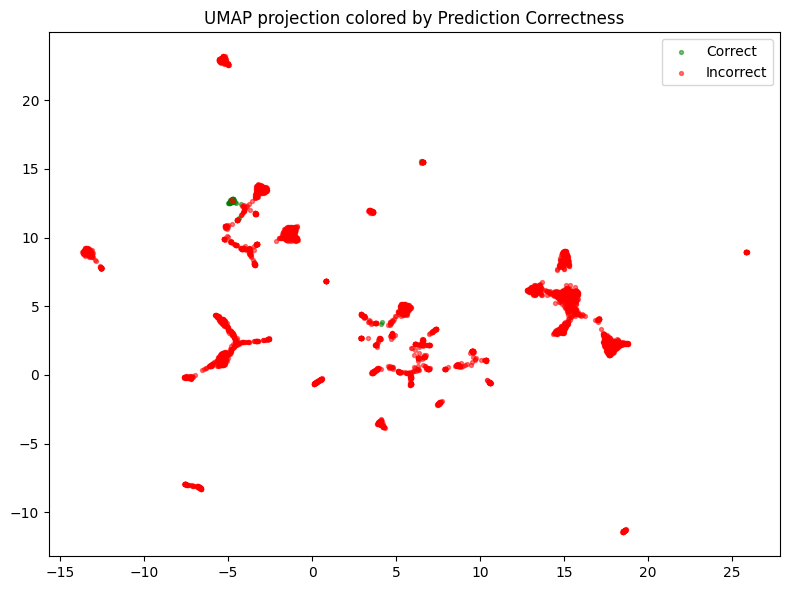

In [ ]:
# pred correctness
correct = (labels_encoded == y_pred)
plt.figure(figsize=(8,6))
plt.scatter(umap_proj[correct,0], umap_proj[correct,1], s=8, c='green', label='Correct', alpha=0.5)
plt.scatter(umap_proj[~correct,0], umap_proj[~correct,1], s=8, c='red', label='Incorrect', alpha=0.5)
plt.legend()
plt.title("UMAP projection colored by Prediction Correctness")
plt.tight_layout()
plt.show()

As can be seen, red points = incorrect predictions. Only some green (correct preds) are shown. This visualization directly confirms model failure to learn reliable decision boundaries, as correct predictions are exceedingly rare and unclustered. Even when latent space separates some classifier, classifier head isn't able to use this for accurace prediction.

In [15]:
from sklearn.metrics import silhouette_score

# By true label
score_label = silhouette_score(umap_proj, labels_encoded)
print(f"Silhouette score by true label: {score_label:.3f}")

# By correctness
score_corr = silhouette_score(umap_proj, correct.astype(int))
print(f"Silhouette score by correctness: {score_corr:.3f}")

Silhouette score by true label: 0.128
Silhouette score by correctness: 0.034


By true label: 0.128 -> weak and diffuse class clusters in the latent space
By prediction correctness: 0.034 -> confirms that correct predictions don't form distinct clusters in the learned embedding space

Conclusion: model’s latent space didn't organize data into semantically meaningful or decision-useful clusters

###  **Cross-Modal Retrieval Analysis (Baseline/Proxy)**

In [ ]:
from transformers import AutoTokenizer, AutoModel

# extracting text embeddings
texts = test_df['description'].fillna("").astype(str).tolist()
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert = AutoModel.from_pretrained("distilbert-base-uncased").to(DEVICE)
bert.eval()

text_embeds = []
BATCH_SIZE = 64
with torch.no_grad():
    for start in tqdm(range(0, len(texts), BATCH_SIZE)):
        batch_texts = texts[start:start+BATCH_SIZE]
        enc = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        for k in enc:
            enc[k] = enc[k].to(DEVICE)
        outputs = bert(**enc)
        pooled = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        text_embeds.append(pooled.cpu().numpy())
text_embeds = np.concatenate(text_embeds, axis=0)  # shape: [N, 768]
print("text_embeds shape:", text_embeds.shape)

100%|██████████| 56/56 [03:03<00:00,  3.27s/it]

text_embeds shape: (3555, 768)


In [ ]:
# img embeddings
image_embeds = np.load(TEST_IMG_EMB)  # shape: [N, 512]

match dimensionality: text is ([CLS]) is 768-dim, images are 512-dim. we reduce both to 128-D using PCA before computing similarities

In [18]:
from sklearn.decomposition import PCA

pca_dim = 128
pca_text = PCA(n_components=pca_dim).fit_transform(text_embeds)
pca_img = PCA(n_components=pca_dim).fit_transform(image_embeds)
print("PCA shapes:", pca_text.shape, pca_img.shape)

PCA shapes: (3555, 128) (3555, 128)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Normalize embeddings
from sklearn.preprocessing import normalize
pca_text_norm = normalize(pca_text)
pca_img_norm = normalize(pca_img)

# Computing cosine similarity matrices
sim_text_to_img = cosine_similarity(pca_text_norm, pca_img_norm)  # [N_text, N_img]

In [ ]:
# RETRIEVAL METRICS: Recall@K and MRR

def recall_at_k(sim_mat, k):
    ranks = np.argsort(-sim_mat, axis=1)  # Descending order
    hits = [i in ranks[i, :k] for i in range(sim_mat.shape[0])]
    return np.mean(hits)

def mean_reciprocal_rank(sim_mat):
    ranks = np.argsort(-sim_mat, axis=1)
    rr = []
    for i in range(sim_mat.shape[0]):
        rank = np.where(ranks[i] == i)[0]
        rr.append(1.0 / (rank[0] + 1) if len(rank) > 0 else 0.0)
    return np.mean(rr)

for K in [1, 5, 10]:
    r_at_k = recall_at_k(sim_text_to_img, k=K)
    print(f"Text-to-Image Recall@{K}: {r_at_k:.4f}")
mrr = mean_reciprocal_rank(sim_text_to_img)
print(f"Text-to-Image MRR: {mrr:.4f}")

# Image-to-Text (just transpose sim_mat)
sim_img_to_text = sim_text_to_img.T
for K in [1, 5, 10]:
    r_at_k = recall_at_k(sim_img_to_text, k=K)
    print(f"Image-to-Text Recall@{K}: {r_at_k:.4f}")
mrr = mean_reciprocal_rank(sim_img_to_text)
print(f"Image-to-Text MRR: {mrr:.4f}")

Text-to-Image Recall@1: 0.0003
Text-to-Image Recall@5: 0.0017
Text-to-Image Recall@10: 0.0028
Text-to-Image MRR: 0.0025
Image-to-Text Recall@1: 0.0003
Image-to-Text Recall@5: 0.0011
Image-to-Text Recall@10: 0.0025
Image-to-Text MRR: 0.0023


Text-to-Image Retrieval

In [21]:
import random
N = sim_text_to_img.shape[0]
K = 5  # top-K to display

for i in random.sample(range(N), 5):  # Show 5 random examples
    true_label = test_df.iloc[i]['label']
    description = test_df.iloc[i]['description'][:300]  # Truncate for clarity
    
    # Top K retrieved image indices
    top_k_idx = np.argsort(-sim_text_to_img[i])[:K]
    print(f"\n--- Example {i} ---")
    print(f"Text query (idx={i}): {description}")
    print(f"True label: {true_label}")
    
    print("Top-K retrieved image labels:")
    for rank, idx in enumerate(top_k_idx):
        retrieved_label = test_df.iloc[idx]['label']
        flag = "(CORRECT)" if idx == i else ""
        print(f"  Rank {rank+1}: idx={idx} | Label: {retrieved_label} {flag}")


--- Example 26 ---
Text query (idx=26): the chuck taylor all star is a symbol of originality and self-expression the world over. the pioneers that put the amp;lsquo squeakamp;rsquo  in basketball have been an off-the-court favourite of rock stars and rebels for the past 60 years. dedicated to basketball champ chuck taylor, this chuck tayl
True label: Casual Shoes
Top-K retrieved image labels:
  Rank 1: idx=2289 | Label: Kurtas 
  Rank 2: idx=2326 | Label: Tops 
  Rank 3: idx=361 | Label: Tops 
  Rank 4: idx=2548 | Label: Tunics 
  Rank 5: idx=1678 | Label: Tops 

--- Example 2820 ---
Text query (idx=2820): this sleeker shoe from fila is great for casual wear. they give superior traction and protection to the feet while remaining comfortable and stylish. team these with jeans and t-shirts for a great casual look. comes with contrasting pairs of laces. upper fabric upper with a rubber toe tox central la
True label: Casual Shoes
Top-K retrieved image labels:
  Rank 1: idx=1735 | Label: F

Image-to-Text Retrieval

In [ ]:
for i in random.sample(range(N), 5):  # 5 random image queries
    true_label = test_df.iloc[i]['label']
    image_path = test_df.iloc[i]['image_path']
    
    # Top K retrieved text indices
    top_k_idx = np.argsort(-sim_img_to_text[i])[:K]
    print(f"\n--- Example {i} ---")
    print(f"Image query (idx={i}): {image_path}")
    print(f"True label: {true_label}")
    
    print("Top-K retrieved text labels:")
    for rank, idx in enumerate(top_k_idx):
        retrieved_label = test_df.iloc[idx]['label']
        flag = "(CORRECT)" if idx == i else ""
        retrieved_desc = test_df.iloc[idx]['description'][:120].replace("\n"," ")
        print(f"  Rank {rank+1}: idx={idx} | Label: {retrieved_label} {flag}")
        print(f"    Retrieved desc: {retrieved_desc}")


--- Example 1650 ---
Image query (idx=1650): D:/COmparative_Study_of_Multimodal_Represenations/data/raw/fashionai/data/25437.jpg
True label: Wallets
Top-K retrieved text labels:
  Rank 1: idx=2844 | Label: Tshirts 
    Retrieved desc: blue polo t-shirt that has short sleeves, adidas patent stripes down the shoulders towards the sleeves on the front and 
  Rank 2: idx=145 | Label: Tshirts 
    Retrieved desc: white polo t-shirt, has a polo collar, short sleeves, short button placket, vented hem
  Rank 3: idx=2292 | Label: Trunk 
    Retrieved desc: navy blue trunks that have a broad, elasticated gold coloured waistband, stitch detailing, printed branding on the waist
  Rank 4: idx=1342 | Label: Tshirts 
    Retrieved desc: navy blue polo t-shirt, has a polo collar, short sleeves, short button placket, vented hem
  Rank 5: idx=2164 | Label: Tshirts 
    Retrieved desc: blue polo t-shirt, has a polo collar, short button placket, short sleeves, a patch pocket, vented hem

--- Example 788 

Cross-Modal Retrieval Analysis

1. Quantitative Retrieval Performance:  to evaluate whether model's representation space aligns semantically similar text and image pairs,  "text-to-image" and "image-to-text" retrievals are performed on test set using pre-fusion BERT and image embeddings (PCA-reduced to a shared 128D space).
* Text-to-Img & Img-to-Text values are essentially random chance (far <1%), meaning that current model architecture don't produce a semantically meaningful joint embedding space for cross-modal retrieval.

2. Qualitative Examples

* Text-to-Img Retrieval: for a sample text description about "handbags", top-retrived imgs were all labeled as "sports shoes" (no semantic relation to the query)
* Img-to-Text Retrieval: for an image labeled “formal shoes” the top retrieved descriptions were about “rrack pants,” “backpacks,” or “tshirts.”

Conclusion:
* no cross-modal alignment: no meaningful relationships between img and text modalities;  
* class imbalance -> failure 

## 2. Late Fusion

In [ ]:
TEST_CSV = DATA_PROCESSED / "fashion" / "test.csv"
TEST_IMG_EMB = DATA_PROCESSED / "fashion" / "test_image_emb.npy"
LATE_MODEL_PATH = CHECKPOINTS / "default" / "fashion_classical_late" / "last.ckpt"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64

# Load data
test_df = pd.read_csv(TEST_CSV)
image_embeddings = np.load(TEST_IMG_EMB)
texts = test_df['description'].fillna("").astype(str).tolist()
labels = test_df['label'].astype(str).tolist()

# Build label encoder on the fly 
unique_labels = sorted(set(labels))
label2idx = {label: idx for idx, label in enumerate(unique_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}
labels_encoded = np.array([label2idx[label] for label in labels])

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# import sys
# sys.path.append("D:/COmparative_Study_of_Multimodal_Represenations/src")
from comparative.models.classical.late_fusion import LateFusionClassifier

model = LateFusionClassifier.load_from_checkpoint(LATE_MODEL_PATH)
model.to(DEVICE)
model.eval()

y_pred = []
logits_all = []

for start in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch_texts = texts[start:start+BATCH_SIZE]
    batch_imgs = image_embeddings[start:start+BATCH_SIZE]
    enc = tokenizer(
        batch_texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    batch = {k: v.to(DEVICE) for k, v in enc.items()}
    batch['image_emb'] = torch.tensor(batch_imgs).float().to(DEVICE)
    with torch.no_grad():
        logits = model(batch)
    y_pred.extend(logits.argmax(dim=1).cpu().numpy())
    logits_all.append(logits.cpu().numpy())

y_pred = np.array(y_pred)
logits_all = np.concatenate(logits_all, axis=0)
print("Inference done! y_pred shape:", y_pred.shape)

100%|██████████| 56/56 [03:00<00:00,  3.22s/it]

Inference done! y_pred shape: (3555,)


Accuracy: 0.0203
Precision: 0.0203
Recall: 0.0203
F1 Score: 0.0203


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,precision,recall,f1-score,support
Accessory Gift Set,1.000000,1.000000,1.000000,8.0
Baby Dolls,0.000000,0.000000,0.000000,1.0
Backpacks,0.964286,0.947368,0.955752,57.0
Bangle,0.875000,1.000000,0.933333,7.0
Basketballs,1.000000,1.000000,1.000000,1.0
...,...,...,...,...
Water Bottle,0.000000,0.000000,0.000000,1.0
Wristbands,0.000000,0.000000,0.000000,1.0
micro avg,0.029545,0.020253,0.024032,3555.0
macro avg,0.041361,0.042285,0.041787,3555.0


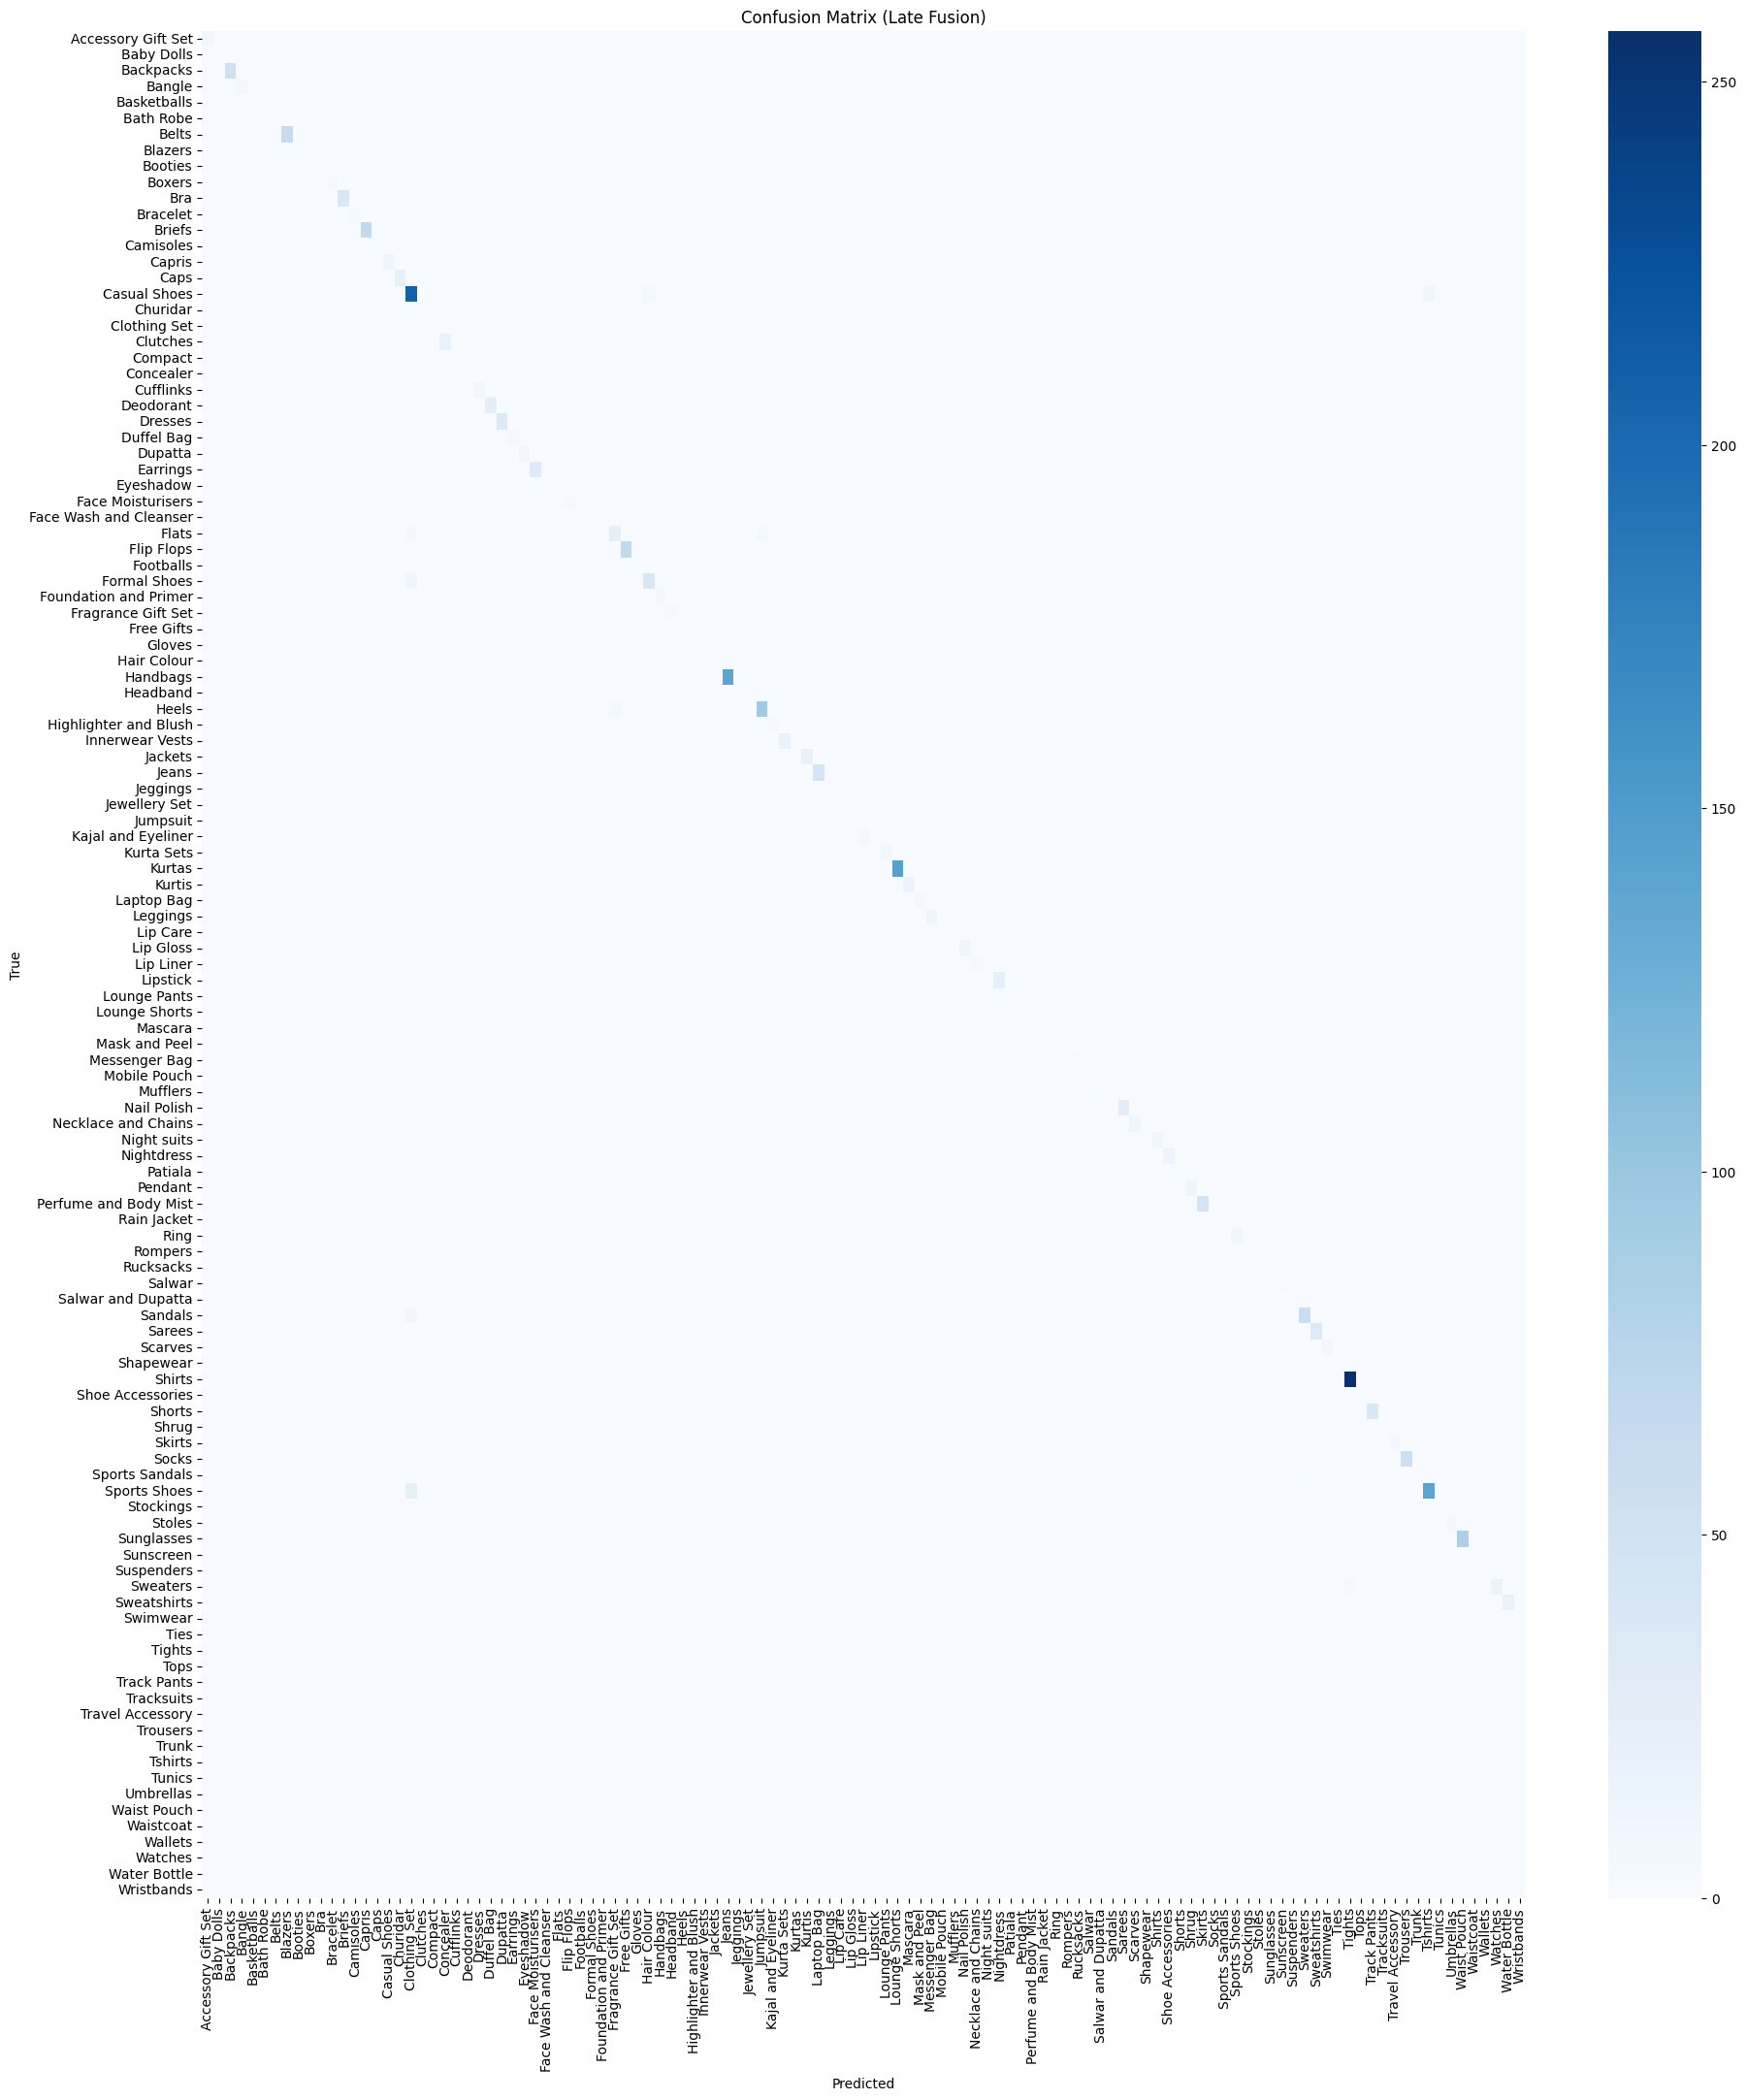

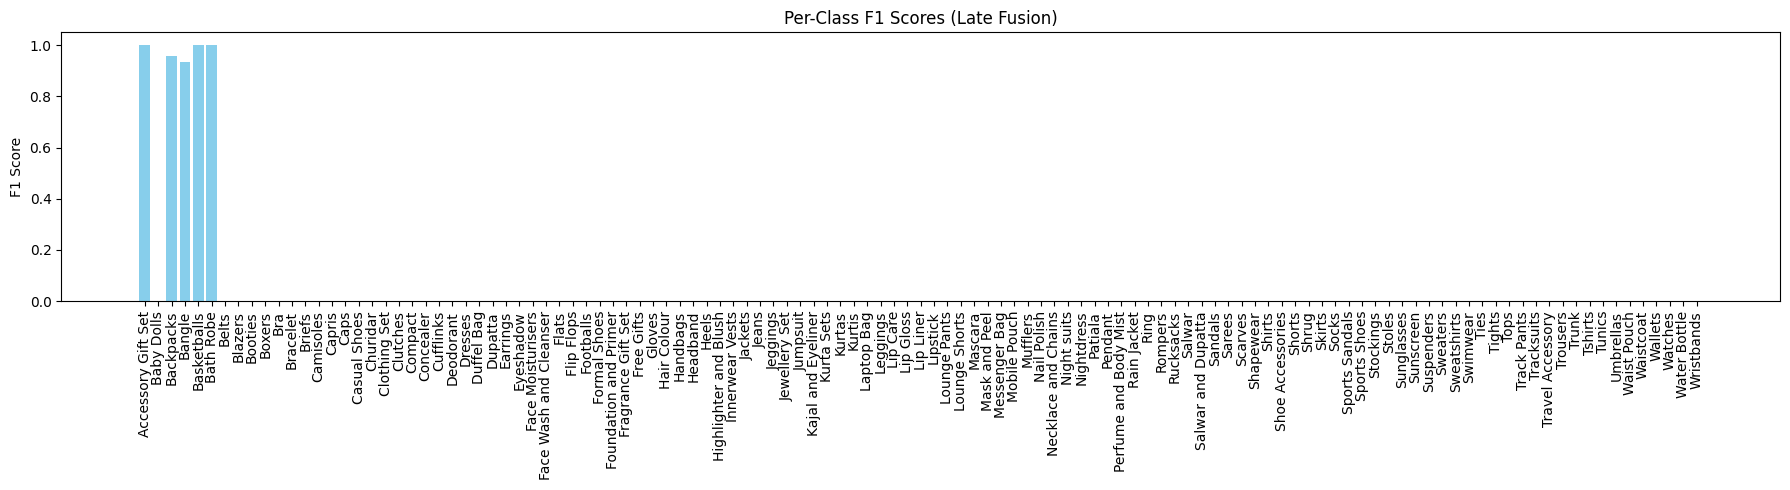

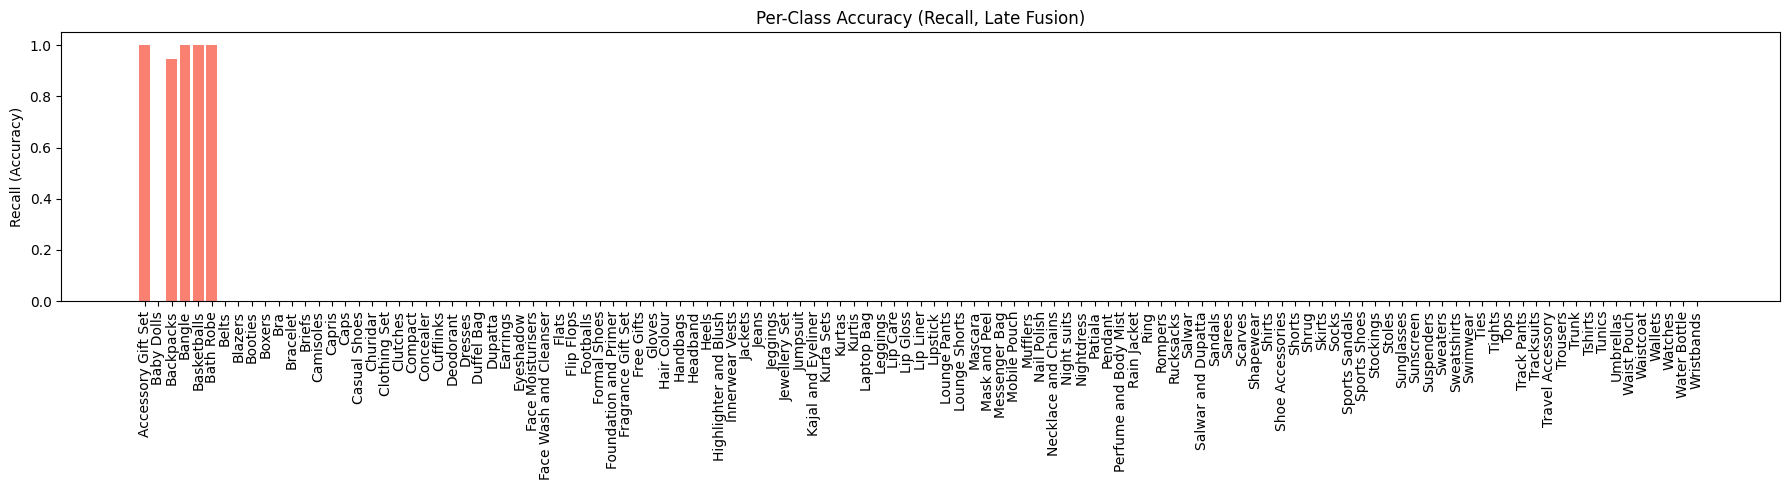

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

all_labels = [label for label, idx in sorted(label2idx.items(), key=lambda x: x[1])]
n_classes = len(all_labels)

acc = accuracy_score(labels_encoded, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(labels_encoded, y_pred, average='weighted')
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

class_report = classification_report(
    labels_encoded, y_pred,
    labels=list(range(n_classes)),
    target_names=all_labels,
    output_dict=True,
    zero_division=0
)
df_report = pd.DataFrame(class_report).transpose()
display(df_report)

# Confusion matrix
cm = confusion_matrix(labels_encoded, y_pred, labels=list(range(n_classes)))
plt.figure(figsize=(22, 25))
sns.heatmap(cm, annot=False, xticklabels=all_labels, yticklabels=all_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Late Fusion)')
plt.show()

# Per-class F1 barplot
f1_scores = [class_report.get(cls, {}).get('f1-score', 0.0) for cls in all_labels]
plt.figure(figsize=(18, 5))
plt.bar(all_labels, f1_scores, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores (Late Fusion)")
plt.tight_layout()
plt.show()

# Per-class Recall barplot
recalls = [class_report.get(cls, {}).get('recall', 0.0) for cls in all_labels]
plt.figure(figsize=(18, 5))
plt.bar(all_labels, recalls, color='salmon')
plt.xticks(rotation=90)
plt.ylabel("Recall (Accuracy)")
plt.title("Per-Class Accuracy (Recall, Late Fusion)")
plt.tight_layout()
plt.show() 

* From confusion matrix we see most of matrix is empty (no correct predictions for majority of categories), non-zero diagonals correspond to head classes that dominate training data
* Per-class F1/Recall: here only some classes achieve meaningful F1 scores (0.9+), while majority of classes show 0 precision, recall, and F1 which means that model FAILS to correctly predict or attempt to predict rare classes;

Conclusion: late fusion model, same as early fusion, can't overcome severe class imbalance present in the dataset. 

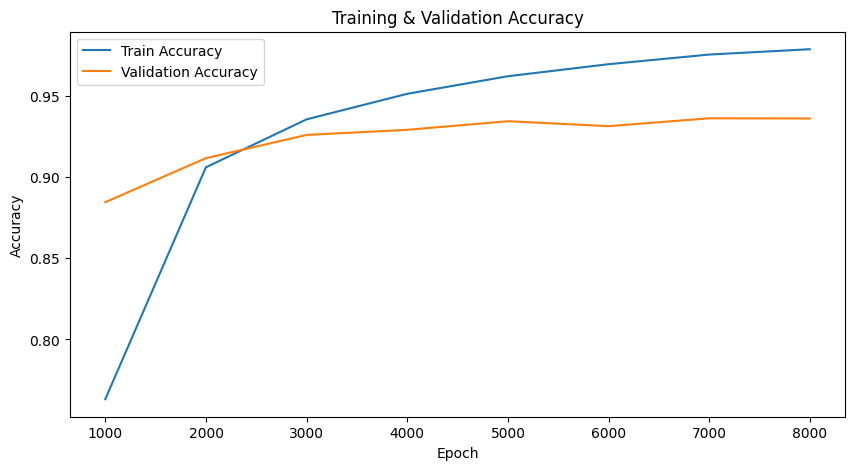

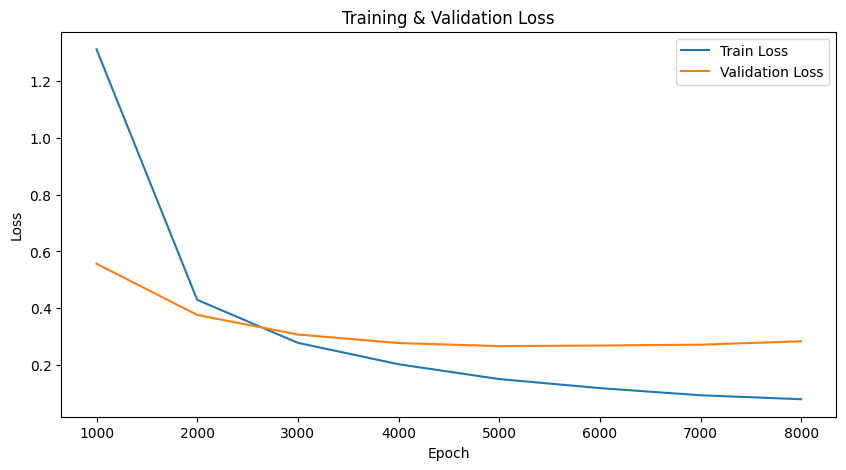

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import pandas as pd
EVENTS_PATH = CHECKPOINTS / "lightning_logs" / "fashion_classical_late" / "version_1" / "events.out.tfevents.1751979766"
#print(event_acc.Tags()) --> show all available tags in the event file

event_acc = EventAccumulator(EVENTS_PATH)
event_acc.Reload()

# extract epoch-wise metrics
val_accuracies = event_acc.Scalars('val_acc')
train_accuracies = event_acc.Scalars('train_acc_epoch')
val_losses = event_acc.Scalars('val_loss')
train_losses = event_acc.Scalars('train_loss_epoch')

# convert to df
val_acc_df = pd.DataFrame(val_accuracies)
train_acc_df = pd.DataFrame(train_accuracies)
val_loss_df = pd.DataFrame(val_losses)
train_loss_df = pd.DataFrame(train_losses)

# acc plot
plt.figure(figsize=(10, 5))
plt.plot(train_acc_df['step'], train_acc_df['value'], label='Train Accuracy')
plt.plot(val_acc_df['step'], val_acc_df['value'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()

# loss plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df['step'], train_loss_df['value'], label='Train Loss')
plt.plot(val_loss_df['step'], val_loss_df['value'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [ ]:
# extracting final fusion embeddings for late fusion 

# model setup 
model.eval()
all_embeddings = []
y_pred = []

BATCH_SIZE = 64

for start in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch_texts = texts[start:start+BATCH_SIZE]
    batch_imgs = image_embeddings[start:start+BATCH_SIZE]
    enc = tokenizer(
        batch_texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    batch = {k: v.to(DEVICE) for k, v in enc.items()}
    batch['image_emb'] = torch.tensor(batch_imgs).float().to(DEVICE)
    with torch.no_grad():
        # Text branch
        text_out = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        pooled = text_out.last_hidden_state[:, 0, :]
        features = [pooled, batch['image_emb']]
        # If you had other branches, add here as in your model (e.g. image, graph)
        fused = torch.cat(features, dim=1)
        fused_vec = torch.relu(model.fusion(fused))  # This is your embedding
        logits = model.head(fused_vec)
        all_embeddings.append(fused_vec.cpu().numpy())
        y_pred.extend(logits.argmax(dim=1).cpu().numpy())

embeddings_late = np.concatenate(all_embeddings, axis=0)
y_pred = np.array(y_pred)
print("Late fusion embeddings shape:", embeddings_late.shape)
print("Pred shape:", y_pred.shape)

100%|██████████| 56/56 [03:01<00:00,  3.24s/it]

Late fusion embeddings shape: (3555, 256)
Pred shape: (3555,)


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


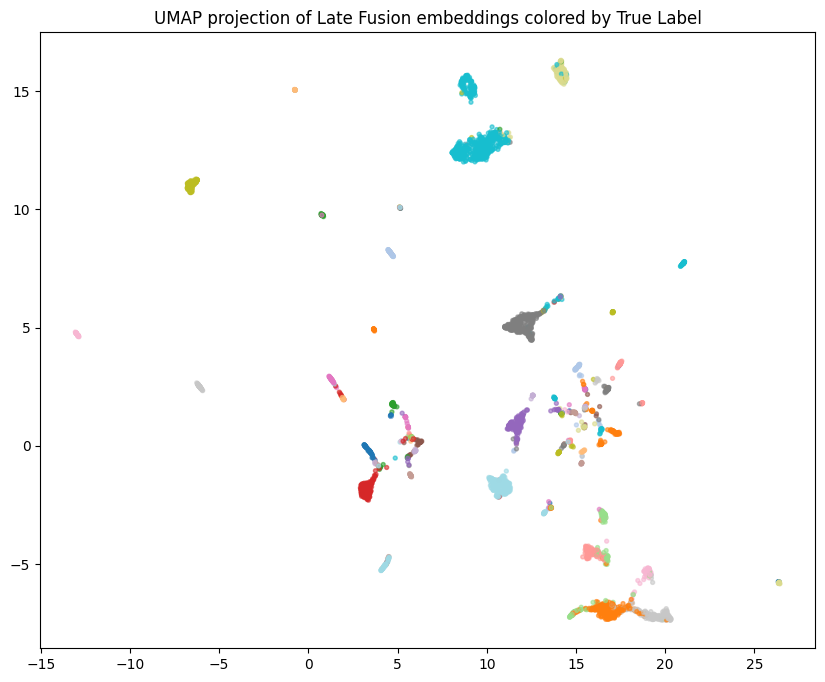

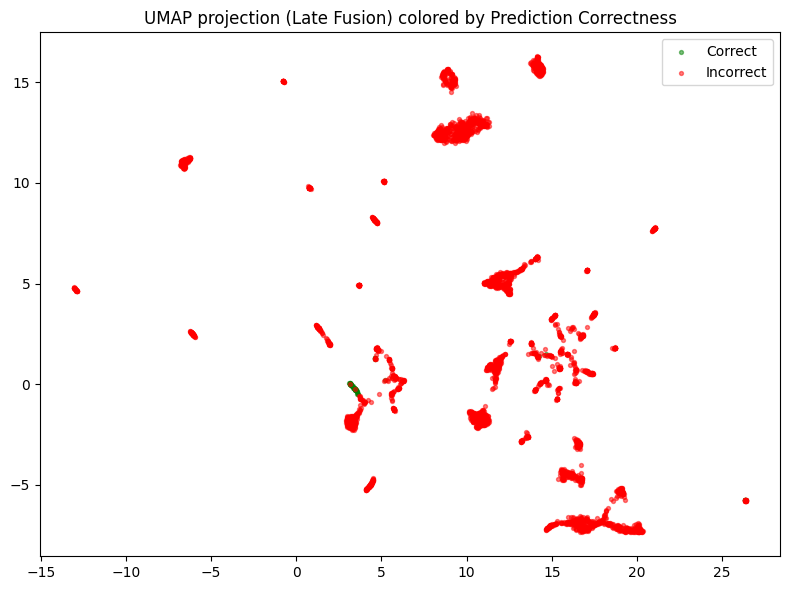

In [28]:
import umap
import matplotlib.pyplot as plt

umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings_late)

# Plot by true label
plt.figure(figsize=(10,8))
scatter = plt.scatter(umap_proj[:, 0], umap_proj[:, 1], c=labels_encoded, cmap='tab20', s=8, alpha=0.6)
plt.title("UMAP projection of Late Fusion embeddings colored by True Label")
plt.show()

# Plot by prediction correctness
correct = (labels_encoded == y_pred)
plt.figure(figsize=(8,6))
plt.scatter(umap_proj[correct,0], umap_proj[correct,1], s=8, c='green', label='Correct', alpha=0.5)
plt.scatter(umap_proj[~correct,0], umap_proj[~correct,1], s=8, c='red', label='Incorrect', alpha=0.5)
plt.legend()
plt.title("UMAP projection (Late Fusion) colored by Prediction Correctness")
plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import silhouette_score

score_label = silhouette_score(umap_proj, labels_encoded)
score_corr = silhouette_score(umap_proj, correct.astype(int))
print(f"Silhouette score by true label (Late Fusion): {score_label:.3f}")
print(f"Silhouette score by correctness (Late Fusion): {score_corr:.3f}")

Silhouette score by true label (Late Fusion): 0.148
Silhouette score by correctness (Late Fusion): 0.022


Still model's internal space is only weakly aligned with true semantic structure, and errors remain widely distributed. 

#### Cross-Modal Retrieval

In [ ]:
# extracting bert text embeddings 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
texts = test_df['description'].fillna("").astype(str).tolist()

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert = AutoModel.from_pretrained("distilbert-base-uncased").to(DEVICE)
bert.eval()

text_embeds = []
BATCH_SIZE = 64
with torch.no_grad():
    for start in tqdm(range(0, len(texts), BATCH_SIZE)):
        batch_texts = texts[start:start+BATCH_SIZE]
        enc = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        for k in enc:
            enc[k] = enc[k].to(DEVICE)
        outputs = bert(**enc)
        pooled = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        text_embeds.append(pooled.cpu().numpy())
text_embeds = np.concatenate(text_embeds, axis=0)

100%|██████████| 56/56 [03:04<00:00,  3.29s/it]


In [ ]:
image_embeds = np.load(TEST_IMG_EMB)  # shape: [N, 512] # img embeddings 

In [ ]:
from sklearn.decomposition import PCA
# pca to align dimension 
pca_dim = 128
pca_text = PCA(n_components=pca_dim).fit_transform(text_embeds)
pca_img = PCA(n_components=pca_dim).fit_transform(image_embeds)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# normalizing and computing cosine similarity
pca_text_norm = normalize(pca_text)
pca_img_norm = normalize(pca_img)

sim_text_to_img = cosine_similarity(pca_text_norm, pca_img_norm)
sim_img_to_text = sim_text_to_img.T

In [34]:
def recall_at_k(sim_mat, k):
    ranks = np.argsort(-sim_mat, axis=1)
    hits = [i in ranks[i, :k] for i in range(sim_mat.shape[0])]
    return np.mean(hits)

def mean_reciprocal_rank(sim_mat):
    ranks = np.argsort(-sim_mat, axis=1)
    rr = []
    for i in range(sim_mat.shape[0]):
        rank = np.where(ranks[i] == i)[0]
        rr.append(1.0 / (rank[0] + 1) if len(rank) > 0 else 0.0)
    return np.mean(rr)

for K in [1, 5, 10]:
    r_at_k = recall_at_k(sim_text_to_img, k=K)
    print(f"Text-to-Image Recall@{K} (Late Fusion): {r_at_k:.4f}")
mrr = mean_reciprocal_rank(sim_text_to_img)
print(f"Text-to-Image MRR (Late Fusion): {mrr:.4f}")

for K in [1, 5, 10]:
    r_at_k = recall_at_k(sim_img_to_text, k=K)
    print(f"Image-to-Text Recall@{K} (Late Fusion): {r_at_k:.4f}")
mrr = mean_reciprocal_rank(sim_img_to_text)
print(f"Image-to-Text MRR (Late Fusion): {mrr:.4f}")

Text-to-Image Recall@1 (Late Fusion): 0.0003
Text-to-Image Recall@5 (Late Fusion): 0.0017
Text-to-Image Recall@10 (Late Fusion): 0.0031
Text-to-Image MRR (Late Fusion): 0.0025
Image-to-Text Recall@1 (Late Fusion): 0.0006
Image-to-Text Recall@5 (Late Fusion): 0.0014
Image-to-Text Recall@10 (Late Fusion): 0.0031
Image-to-Text MRR (Late Fusion): 0.0025


In [35]:
import random

K = 5  # Top-K retrieved images to show per query
N = sim_text_to_img.shape[0]

for i in random.sample(range(N), 5):  # Show 5 random examples
    true_label = test_df.iloc[i]['label']
    description = test_df.iloc[i]['description'][:300]  # Truncated for display
    
    # Top K retrieved image indices
    top_k_idx = np.argsort(-sim_text_to_img[i])[:K]
    print(f"\n--- Text Query Example {i} ---")
    print(f"Text query (idx={i}): {description}")
    print(f"True label: {true_label}")
    print("Top-K retrieved image labels:")
    for rank, idx in enumerate(top_k_idx):
        retrieved_label = test_df.iloc[idx]['label']
        flag = "(CORRECT)" if idx == i else ""
        print(f"  Rank {rank+1}: idx={idx} | Label: {retrieved_label} {flag}")


--- Text Query Example 2982 ---
Text query (idx=2982): dress your infant in style with this timberland hollyberry crib shoe. made of supple premium nubuck leather with a high ankle, this bootie is sure to keep your infant safe from the winter chill and comfortable to the hilt. upper lightweight, flexible construction designed as a foot covering, and has
True label: Casual Shoes
Top-K retrieved image labels:
  Rank 1: idx=2085 | Label: Track Pants 
  Rank 2: idx=2013 | Label: Track Pants 
  Rank 3: idx=1301 | Label: Sweatshirts 
  Rank 4: idx=2743 | Label: Lounge Pants 
  Rank 5: idx=2832 | Label: Track Pants 

--- Text Query Example 2235 ---
Text query (idx=2235): composition blue v-neck t-shirt made of 87% polyester and 13% spandex, has short raglan sleeves, white panels under the armholes, mesh panel at the back and nike swoosh on the left chest fit slim wash care machine wash with cold water using a mild detergent do not use softeners do not bleach, iron o
True label: Tshirts
Top-K

In [ ]:
for i in random.sample(range(N), 5):  # 5 random image queries
    true_label = test_df.iloc[i]['label']
    image_path = test_df.iloc[i]['image_path']
    
    # Top K retrieved text indices
    top_k_idx = np.argsort(-sim_img_to_text[i])[:K]
    print(f"\n--- Image Query Example {i} ---")
    print(f"Image query (idx={i}): {image_path}")
    print(f"True label: {true_label}")
    print("Top-K retrieved text labels:")
    for rank, idx in enumerate(top_k_idx):
        retrieved_label = test_df.iloc[idx]['label']
        flag = "(CORRECT)" if idx == i else ""
        retrieved_desc = test_df.iloc[idx]['description'][:120].replace("\n", " ")
        print(f"  Rank {rank+1}: idx={idx} | Label: {retrieved_label} {flag}")
        print(f"    Retrieved desc: {retrieved_desc}")


--- Image Query Example 832 ---
Image query (idx=832): D:/COmparative_Study_of_Multimodal_Represenations/data/raw/fashionai/data/32802.jpg
True label: Flip Flops
Top-K retrieved text labels:
  Rank 1: idx=439 | Label: Formal Shoes 
    Retrieved desc: take formal dressing to the next level with this leather loafer from red tape. the full grain leather lends it a natural
  Rank 2: idx=1790 | Label: Sports Shoes 
    Retrieved desc: mesh and synthetic upper with a sleek design and no fussy overlay; has central lace-ups has a padded inner and a tough h
  Rank 3: idx=1802 | Label: Trunk 
    Retrieved desc: composition grey with black, blue and yellow stripes brief made of 100% combed cotton ribbed fabric, has a cushioned sig
  Rank 4: idx=1514 | Label: Track Pants 
    Retrieved desc: composition grey trackpant made of 100% polyester, has a mesh inner lining, elasticated waist with a drawstring, two poc
  Rank 5: idx=1534 | Label: Sports Shoes 
    Retrieved desc: the fila swift with its

Conclusion: based on provided analysis for both fusion strategies, it can be concluded that fusion architecture alone can't compensate for dataset imbalance. Both are "overwhelmed" by head classes, and neither achieves reliable semantic or cross-modal alignment.

## 3. CLIP & ViLBERT Modules

In [ ]:
import os
from pathlib import Path
from tensorboard.backend.event_processing import event_accumulator

# RUN_DIR = "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/lightning_logs/fashion_clip/version_2/"
RUN_DIR = CHECKPOINTS / "lightning_logs" / "fashion_clip" / "version_2"
event_files = [str(p) for p in Path(RUN_DIR).glob("events.out.tfevents.*")]
assert len(event_files), f"No event files found in {RUN_DIR}"
event_files.sort(key=os.path.getmtime)
event_path = event_files[-1]

print(f"Reading event file: {event_path}")

ea = event_accumulator.EventAccumulator(
    event_path,
    size_guidance={
        event_accumulator.SCALARS: 0,  # load all scalars
    },
)
ea.Reload()

def get_series(tag):
    if tag not in ea.Tags().get("scalars", []):
        return []
    return [(e.step, e.value) for e in ea.Scalars(tag)]

def summarize_series(name, series):
    if not series:
        return
    steps, vals = zip(*series)
    print(f"\n{name}:")
    print(f"  first step={steps[0]}  first val={vals[0]:.4f}")
    print(f"  last  step={steps[-1]} last  val={vals[-1]:.4f}")
    print(f"  min   val={min(vals):.4f} at step={steps[vals.index(min(vals))]}")
    print(f"  max   val={max(vals):.4f} at step={steps[vals.index(max(vals))]}")

for tag in [
    "train/loss",        # epoch-avg training loss
    "train/loss_step",   # per-step loss snapshots
    "val_loss",          # our proxy validation loss
    "val/sim_diag",      # mean diag similarity image<->text
    "train/temp_step",   # effective temperature
]:
    series = get_series(tag)
    summarize_series(tag, series)

print("\nDone.")


Reading event file: D:\COmparative_Study_of_Multimodal_Represenations\src\comparative\checkpoints\lightning_logs\fashionai_clip\version_2\events.out.tfevents.1761302956.ws-zelazny.1229977.0

train/loss_step:
  first step=4  first val=3.0877
  last  step=14999 last  val=0.2637
  min   val=0.0097 at step=13354
  max   val=3.0877 at step=4

val_loss:
  first step=999  first val=-4.5942
  last  step=14999 last  val=-11.1703
  min   val=-11.1703 at step=14999
  max   val=-4.5942 at step=999

val/sim_diag:
  first step=999  first val=4.5942
  last  step=14999 last  val=11.1703
  min   val=4.5942 at step=999
  max   val=11.1703 at step=14999

train/temp_step:
  first step=4  first val=0.0700
  last  step=14999 last  val=0.0210
  min   val=0.0210 at step=14999
  max   val=0.0700 at step=4

Done.


In [16]:
PROJECT_ROOT

WindowsPath('D:/COmparative_Study_of_Multimodal_Represenations')

In [ ]:
# setup, configs
import os, json, glob
from pathlib import Path

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

import umap
import matplotlib.pyplot as plt

# project modules
from comparative.datasets.fashion_datamodule import FashionDatamodule
from comparative.models.transformers.clip_emb_module import CLIPDualEncoderFromEmbeds
from comparative.models.transformers.vilbert_embed_module import ViLBERTEmbedClassifier


# PROJECT_ROOT = "D:/COmparative_Study_of_Multimodal_Represenations"
# os.environ["PROJECT_ROOT"] = PROJECT_ROOT

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
MAX_LEN = 128
IMG_SIZE = 224  # unused when using precomputed image_emb

CKPT_CLIP = CHECKPOINTS / "default" / "fashion_clip" / "last.ckpt"
CKPT_VILBERT = CHECKPOINTS / "default" / "fashion_vilbert" / "last.ckpt"

# CKPT_CLIP = "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashion_clip/last.ckpt"      
# CKPT_VILBERT = "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashion_vilbert/last.ckpt"  

def find_latest_ckpt(root: str, name_hint: str):
    """
    Try to find the most recent .ckpt under <root> whose path contains name_hint.
    """
    pattern = str(Path(root) / "**" / "*.ckpt")
    candidates = [p for p in glob.glob(pattern, recursive=True) if name_hint in p.lower()]
    if not candidates:
        return ""
    candidates.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return candidates[0]

if not CKPT_CLIP:
    CKPT_CLIP = find_latest_ckpt(
        root=f"{PROJECT_ROOT}/src/comparative/checkpoints", name_hint="fashion"
    )  
if not CKPT_VILBERT:
    CKPT_VILBERT = find_latest_ckpt(
        root=f"{PROJECT_ROOT}/src/comparative/checkpoints", name_hint="vilbert"
    )

print("Guessed CLIP ckpt:", CKPT_CLIP)
print("Guessed ViLBERT ckpt:", CKPT_VILBERT)


Guessed CLIP ckpt: D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashionai_clip/last.ckpt
Guessed ViLBERT ckpt: D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashionai_vilbert/last.ckpt


In [ ]:
dm = FashionDatamodule(
    data_dir=f"{PROJECT_ROOT}/data/processed/fashion/",
    tokenizer_name="distilbert-base-uncased",
    batch_size=BATCH_SIZE,
    max_len=MAX_LEN,
    img_size=IMG_SIZE,
    num_workers=4,
    train_samples=None,
    val_samples=None,
)
dm.setup()

train_loader = torch.utils.data.DataLoader(dm.train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_loader   = torch.utils.data.DataLoader(dm.val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("train size:", len(dm.train_ds))
print("val size:", len(dm.val_ds))

train size: 31992 classes: 138
val size:   8889
train size: 31992
val size: 8889


In [42]:
clip_model = CLIPDualEncoderFromEmbeds().to(DEVICE)
state = torch.load(CKPT_CLIP, map_location=DEVICE)
clip_model.load_state_dict(state["state_dict"], strict=False)
clip_model.eval()

@torch.no_grad()
def clip_forward_batch(batch):
    """
    Uses the module's own tokenizer + text tower and precomputed image_emb.
    Returns L2-normalized (txt_emb, img_emb) in CLIP space.
    """
    # The module expects: batch["text"] => list[str], batch["image_emb"] => FloatTensor[B,512]
    # We'll call its own forward which already encodes + normalizes properly.
    txt_emb, img_emb = clip_model(batch)  # tuple(Tensor[B,512], Tensor[B,512])
    return txt_emb.detach().cpu(), img_emb.detach().cpu()

@torch.no_grad()
def build_val_embeddings(dataloader):
    all_txt, all_img, all_lbl = [], [], []
    for batch in dataloader:
        t, i = clip_forward_batch(batch)
        all_txt.append(t)
        all_img.append(i)
        # labels come as 'labels' (LongTensor[B])
        all_lbl.append(batch["labels"].detach().cpu())
    return torch.cat(all_txt), torch.cat(all_img), torch.cat(all_lbl)

txt_val, img_val, y_val = build_val_embeddings(val_loader)
txt_val.shape, img_val.shape, y_val.shape

(torch.Size([8889, 512]), torch.Size([8889, 512]), torch.Size([8889]))

In [ ]:
def retrieval_metrics(text_emb, image_emb, ks=(1,5,10)):
    text_emb = torch.nn.functional.normalize(text_emb, dim=1)
    image_emb = torch.nn.functional.normalize(image_emb, dim=1)
    sim = text_emb @ image_emb.t()  # (N,N)

    N = sim.size(0)
    ranks_t2i = []
    ranks_i2t = []

    # text -> image ranks
    for i in range(N):
        scores = sim[i]
        rank = (scores > scores[i]).sum().item() + 1
        ranks_t2i.append(rank)

    # image -> text ranks
    sim_i2t = sim.t()
    for i in range(N):
        scores = sim_i2t[i]
        rank = (scores > scores[i]).sum().item() + 1
        ranks_i2t.append(rank)

    def recalls(ranks):
        out = {}
        for k in ks:
            out[f"R@{k}"] = float(np.mean([1.0 if r <= k else 0.0 for r in ranks]))
        out["MRR"] = float(np.mean([1.0/r for r in ranks]))
        out["MedianRank"] = int(np.median(ranks))
        return out

    return recalls(ranks_t2i), recalls(ranks_i2t)

ret_t2i, ret_i2t = retrieval_metrics(txt_val, img_val)
print("Text→Image:", ret_t2i)
print("Image→Text:", ret_i2t)

res_dir = Path(PROJECT_ROOT) / "results" / "fashion"
res_dir.mkdir(parents=True, exist_ok=True)
with open(res_dir / "clip_retrieval_val.json", "w") as f:
    json.dump({"t2i": ret_t2i, "i2t": ret_i2t}, f, indent=2)
print("Saved:", res_dir / "clip_retrieval_val.json")

Text→Image: {'R@1': 0.0001124985937675779, 'R@5': 0.0005624929688378895, 'R@10': 0.001124985937675779, 'MRR': 0.0010912321826531918, 'MedianRank': 4622}
Image→Text: {'R@1': 0.0, 'R@5': 0.0002249971875351558, 'R@10': 0.0006749915626054674, 'MRR': 0.0009212708941960759, 'MedianRank': 4504}
Saved: D:\COmparative_Study_of_Multimodal_Represenations\results\fashionai\clip_retrieval_val.json


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


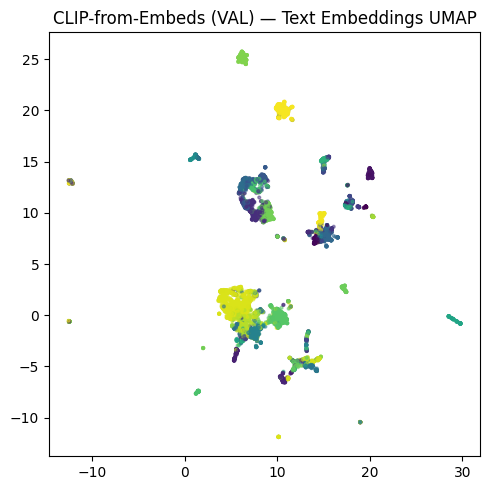

Silhouette (cosine): -0.03166377916932106
Mean kNN agreement@15: 0.7785277684028951
Median kNN agreement@15: 0.9333333333333333


In [44]:
X = txt_val.numpy()
y = y_val.numpy()

um = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="cosine", random_state=42)
X2 = um.fit_transform(X)

plt.figure(figsize=(5,5))
plt.scatter(X2[:,0], X2[:,1], c=y, s=4, alpha=0.5)
plt.title("CLIP-from-Embeds (VAL) — Text Embeddings UMAP")
plt.tight_layout()
plt.show()

# Silhouette & kNN agreement
Xstd = StandardScaler(with_mean=False).fit_transform(X)
sil = silhouette_score(Xstd, y, metric="cosine")

nbrs = NearestNeighbors(n_neighbors=15, metric="cosine").fit(X)
_, idx = nbrs.kneighbors(X)
agree = [(y[i] == y[idx[i]]).mean() for i in range(len(y))]

print("Silhouette (cosine):", float(sil))
print("Mean kNN agreement@15:", float(np.mean(agree)))
print("Median kNN agreement@15:", float(np.median(agree)))

plt.figure(figsize=(5,5))
plt.scatter(X2[:,0], X2[:,1], c=y, s=4, alpha=0.5)
plt.title("CLIP-from-Embeds (VAL) — Text Embeddings UMAP")
plt.tight_layout()
plt.savefig(res_dir / "clip_val_umap.png", dpi=300)
plt.close()

In [45]:
vil_model = ViLBERTEmbedClassifier().to(DEVICE)
state_v = torch.load(CKPT_VILBERT, map_location=DEVICE)
vil_model.load_state_dict(state_v["state_dict"], strict=False)
vil_model.eval()

ViLBERTEmbedClassifier(
  (text_encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
           

In [46]:
@torch.no_grad()
def eval_vilbert_split(dataloader):
    all_logits, all_labels = [], []
    for batch in dataloader:
        logits = vil_model(batch)  # forward(batch) returns (B,C)
        all_logits.append(logits.detach().cpu())
        all_labels.append(batch["labels"].detach().cpu())
    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()
    preds = logits.argmax(axis=1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    report = classification_report(labels, preds, digits=4, zero_division=0, output_dict=True)
    return {"logits": logits, "labels": labels, "preds": preds, "acc": acc, "prec_macro": prec, "rec_macro": rec, "f1_macro": f1, "report": report}

vil_val = eval_vilbert_split(val_loader)
print({k:v for k,v in vil_val.items() if k not in ("logits","labels","preds","report")})

rep_df = pd.DataFrame(vil_val["report"]).T.reset_index().rename(columns={"index":"class"})
res_dir.mkdir(parents=True, exist_ok=True)
rep_df.to_csv(res_dir / "vilbert_val_per_class_metrics.csv", index=False)
rep_df.head()

{'acc': 0.9422882213972326, 'prec_macro': 0.8415031775417094, 'rec_macro': 0.8099724874793541, 'f1_macro': 0.8160817865105724}


,class,precision,recall,f1-score,support
0,0,1.000000,1.000000,1.000000,30.0
1,1,0.000000,0.000000,0.000000,3.0
2,2,0.962500,0.968553,0.965517,159.0
3,3,0.933333,0.933333,0.933333,15.0
4,4,1.000000,1.000000,1.000000,1.0


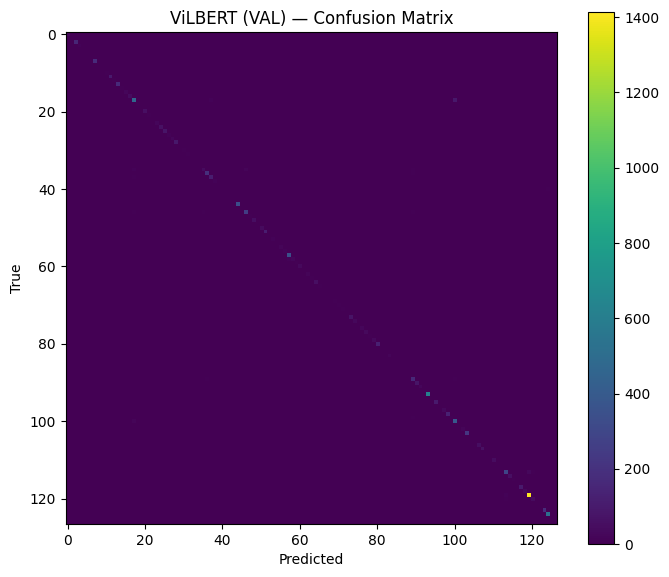

In [ ]:
cm = confusion_matrix(vil_val["labels"], vil_val["preds"])
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation="nearest")
plt.title("ViLBERT (VAL) — Confusion Matrix") # tttttttttttttttttest
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

plt.imsave(res_dir / "vilbert_val_confusion.png", cm)

In [ ]:
train_csv = pd.read_csv(f"{PROJECT_ROOT}/data/processed/fashion/train.csv")
freq = train_csv["label"].value_counts().sort_values(ascending=False)

HEAD_K = 20
head_classes = set(freq.index[:HEAD_K])
tail_classes = set(freq.index[HEAD_K:])

preds = pd.DataFrame({"y_true": vil_val["labels"], "y_pred": vil_val["preds"]})
preds["bucket"] = preds["y_true"].apply(lambda c: "head" if c in head_classes else "tail")

def bucket_metrics(df):
    acc = accuracy_score(df["y_true"], df["y_pred"])
    prec, rec, f1, _ = precision_recall_fscore_support(df["y_true"], df["y_pred"], average="macro", zero_division=0)
    return {"acc":acc, "prec_macro":prec, "rec_macro":rec, "f1_macro":f1}

print("Head metrics:", bucket_metrics(preds[preds["bucket"]=="head"]))
print("Tail metrics:", bucket_metrics(preds[preds["bucket"]=="tail"]))

Head metrics: {'acc': nan, 'prec_macro': nan, 'rec_macro': nan, 'f1_macro': nan}
Tail metrics: {'acc': 0.9422882213972326, 'prec_macro': 0.8415031775417094, 'rec_macro': 0.8099724874793541, 'f1_macro': 0.8160817865105724}


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


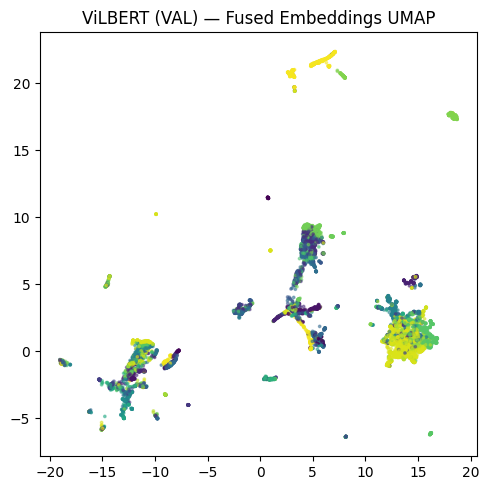

Silhouette (cosine): -0.38661080598831177
Mean kNN agreement@15: 0.6606592417594781
Median kNN agreement@15: 0.7333333333333333


In [ ]:
fused_feats = []

def hook_fn(module, inp, out):
    fused_feats.append(inp[0].detach().cpu())

first_linear = None
for name, m in vil_model.named_modules():
    if isinstance(m, torch.nn.Linear):
        first_linear = m
        break
if first_linear is None:
    raise RuntimeError("Couldn't find a Linear layer to hook.")

handle = first_linear.register_forward_hook(hook_fn)

_ = eval_vilbert_split(val_loader)
handle.remove()

Z = torch.cat(fused_feats, dim=0)
if Z.ndim ==3:
    Z=Z.mean(dim=1)
Z = Z.numpy()
y = vil_val["labels"]

u = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="cosine", random_state=42)
Z2 = u.fit_transform(Z)

plt.figure(figsize=(5,5))
plt.scatter(Z2[:,0], Z2[:,1], c=y, s=3, alpha=0.5)
plt.title("ViLBERT: Fused Embeddings UMAP")
plt.tight_layout()
plt.show()

# Silhouette & kNN
Zstd = StandardScaler(with_mean=False).fit_transform(Z)
sil = silhouette_score(Zstd, y, metric="cosine")

nbrs = NearestNeighbors(n_neighbors=15, metric="cosine").fit(Z)
_, idx = nbrs.kneighbors(Z)
agree = [(y[i] == y[idx[i]]).mean() for i in range(len(y))]

print("Silhouette (cosine):", float(sil))
print("Mean kNN agreement@15:", float(np.mean(agree)))
print("Median kNN agreement@15:", float(np.median(agree)))

plt.figure(figsize=(5,5))
plt.scatter(Z2[:,0], Z2[:,1], c=y, s=3, alpha=0.5)
plt.title("ViLBERT: Fused Embeddings UMAP") # val/test
plt.tight_layout()
plt.savefig(res_dir / "vilbert_val_umap.png", dpi=300)
plt.close()

In [ ]:
import os
import torch
from itertools import islice
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
def peek_batch(dataloader, n=1):
    if n <= 0:
        raise ValueError("n must be >= 1")
    it = iter(dataloader)
    b = None
    for i in range(n):
        try:
            b = next(it)
            print({k: (v.shape if torch.is_tensor(v) else type(v)) for k, v in b.items()})
        except StopIteration:
            if i == 0:
                raise StopIteration("Dataloader is empty. No batch to peek.") from None
            else:
                print(f"Reached end of dataloader after {i} batches.")
            break
    return b

if globals().get('train_loader', None) is None or globals().get('val_loader', None) is None:
    if globals().get('dm', None) is not None:
        BATCH_SIZE = globals().get('BATCH_SIZE', 64)
        train_loader = torch.utils.data.DataLoader(dm.train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
        val_loader   = torch.utils.data.DataLoader(dm.val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    else:
        try:
            from comparative.datasets.fashion_datamodule import fashionDatamodule
        except ModuleNotFoundError:
            import sys, os
            PROJECT_ROOT = globals().get('PROJECT_ROOT', "D:/COmparative_Study_of_Multimodal_Represenations")
            src_path = os.path.join(PROJECT_ROOT, "src")
            if src_path not in sys.path:
                sys.path.append(src_path)
            try:
                from comparative.datasets.fashion_datamodule import FashionDatamodule
            except Exception as e:
                raise ImportError(
                    "Could not import comparative.datasets.fashion_datamodule.FashionDatamodule. "
                    "Ensure your PROJECT_ROOT (or sys.path) is set correctly and package is available."
                ) from e

        PROJECT_ROOT = globals().get('PROJECT_ROOT', "D:/COmparative_Study_of_Multimodal_Represenations")
        BATCH_SIZE = globals().get('BATCH_SIZE', 64)
        MAX_LEN = globals().get('MAX_LEN', 128)
        IMG_SIZE = globals().get('IMG_SIZE', 224)

        dm = fashionDatamodule(
            data_dir=f"{PROJECT_ROOT}/data/processed/fashion/",
            tokenizer_name="distilbert-base-uncased",
            batch_size=BATCH_SIZE,
            max_len=MAX_LEN,
            img_size=IMG_SIZE,
            num_workers=4,
            train_samples=None,
            val_samples=None,
        )
        try:
            dm.setup()
        except Exception:
            pass

        train_loader = torch.utils.data.DataLoader(dm.train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
        val_loader   = torch.utils.data.DataLoader(dm.val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# final sanity check: ensure loaders are defined
if globals().get('train_loader', None) is None or globals().get('val_loader', None) is None:
    raise RuntimeError("train_loader or val_loader is not available. Please create a datamodule or define train_loader/val_loader in the notebook before running this cell.")

print("Train peek:")
train_peek = peek_batch(train_loader, 1)
print("Val peek:")
val_peek = peek_batch(val_loader, 1)

# 'text': list[str], 'image_emb': torch.FloatTensor [B, 512], 'labels': torch.LongTensor [B]

Train peek:
{'text': <class 'list'>, 'image_emb': torch.Size([64, 512]), 'label': torch.Size([64]), 'labels': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
Val peek:
{'text': <class 'list'>, 'image_emb': torch.Size([64, 512]), 'label': torch.Size([64]), 'labels': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}


In [ ]:
clip_model.eval()

@torch.no_grad()
def encode_val_clip(dataloader):
    all_txt, all_img, all_lbl = [], [], []
    for batch in dataloader:
        # Uses clip_model(batch) -> (txt_emb, img_emb), both already L2-normalized in that module
        txt, img = clip_model(batch)
        assert txt.ndim == 2 and img.ndim == 2, f"Expected 2-D, got {txt.shape} {img.shape}"
        assert txt.shape[1] == img.shape[1] == 512, f"Expected 512-d emb, got {txt.shape} {img.shape}"
        all_txt.append(txt.detach().cpu())
        all_img.append(img.detach().cpu())
        all_lbl.append(batch["labels"].detach().cpu())
    return torch.cat(all_txt), torch.cat(all_img), torch.cat(all_lbl)

txt_val, img_val, y_val = encode_val_clip(val_loader)
print("txt_val:", tuple(txt_val.shape), "img_val:", tuple(img_val.shape), "y_val:", tuple(y_val.shape))

txt_val: (8889, 512) img_val: (8889, 512) y_val: (8889,)


In [53]:
def retrieval_metrics(text_emb, image_emb, ks=(1,5,10)):
    text_emb = torch.nn.functional.normalize(text_emb, dim=1)
    image_emb = torch.nn.functional.normalize(image_emb, dim=1)
    sim = text_emb @ image_emb.t()  # (N,N)

    N = sim.size(0)
    ranks_t2i, ranks_i2t = [], []

    # text -> image
    for i in range(N):
        s = sim[i]
        # rank of GT (i) among all images (1 is best)
        rank = (s > s[i]).sum().item() + 1
        ranks_t2i.append(rank)

    # image -> text
    sim_i2t = sim.t()
    for i in range(N):
        s = sim_i2t[i]
        rank = (s > s[i]).sum().item() + 1
        ranks_i2t.append(rank)

    def summarize(ranks):
        ranks = np.asarray(ranks)
        out = {}
        for k in ks:
            out[f"R@{k}"] = float(np.mean(ranks <= k))
        out["MRR"] = float(np.mean(1.0 / ranks))
        out["MedianRank"] = int(np.median(ranks))
        return out

    return summarize(ranks_t2i), summarize(ranks_i2t)

ret_t2i, ret_i2t = retrieval_metrics(txt_val, img_val)
print("CLIP Text→Image:", ret_t2i)
print("CLIP Image→Text:", ret_i2t)


CLIP Text→Image: {'R@1': 0.0001124985937675779, 'R@5': 0.0005624929688378895, 'R@10': 0.001124985937675779, 'MRR': 0.0010912321826531918, 'MedianRank': 4622}
CLIP Image→Text: {'R@1': 0.0, 'R@5': 0.0002249971875351558, 'R@10': 0.0006749915626054674, 'MRR': 0.0009212708941960759, 'MedianRank': 4504}


C:\Users\ntuke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


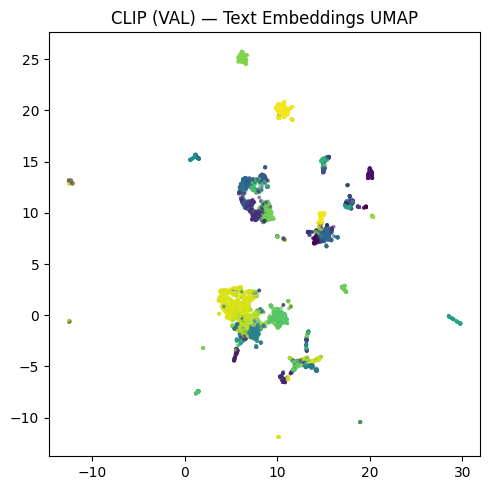

CLIP — Silhouette (cosine): -0.03166377916932106
CLIP — Mean kNN agreement@15: 0.7785277684028951
CLIP — Median kNN agreement@15: 0.9333333333333333


In [ ]:
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

X = txt_val.numpy()
y = y_val.numpy()

# UMAP on cosine space
um = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="cosine", random_state=42)
X2 = um.fit_transform(X)

plt.figure(figsize=(5,5))
plt.scatter(X2[:,0], X2[:,1], c=y, s=3, alpha=0.5)
plt.title("CLIP (VAL) — Text Embeddings UMAP")
plt.tight_layout()
plt.show()

# Silhouette on (optionally) standardised features; cosine metric
Xstd = StandardScaler(with_mean=False).fit_transform(X)
sil = silhouette_score(Xstd, y, metric="cosine")

nbrs = NearestNeighbors(n_neighbors=15, metric="cosine").fit(X)
_, idx = nbrs.kneighbors(X)
agree = [(y[i] == y[idx[i]]).mean() for i in range(len(y))]

print("CLIP — Silhouette (cosine):", float(sil))
print("CLIP — Mean kNN agreement@15:", float(np.mean(agree)))
print("CLIP — Median kNN agreement@15:", float(np.median(agree)))

In [ ]:
import torch, umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# find the LAST Linear (classifier's final layer)
last_linear = None
for name, m in list(vil_model.named_modules()):
    if isinstance(m, torch.nn.Linear):
        last_linear = m
if last_linear is None:
    raise RuntimeError("Couldn't find a Linear layer to hook in ViLBERT.")

fused_feats = []
def hook_fn(module, inp, out):
    x = inp[0].detach().cpu()       # prefer the INPUT to the layer
    if x.ndim == 3:                 # if (B, L, D), pool over tokens
        x = x.mean(dim=1)
    fused_feats.append(x)

handle = last_linear.register_forward_hook(hook_fn)

_ = eval_vilbert_split(val_loader)
handle.remove()

Z = torch.cat(fused_feats, dim=0).numpy()  # (N, D)
y = vil_val["labels"] if isinstance(vil_val["labels"], np.ndarray) else np.asarray(vil_val["labels"])
print("ViLBERT fused feature shape:", Z.shape) # from previous cell 

ViLBERT fused feature shape: (8889, 768)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt


print("Top-1 acc:", vil_val["acc"])
print("Macro-F1 :", vil_val["f1_macro"])

# Per-class table
rep_df = pd.DataFrame(vil_val["report"]).T.reset_index().rename(columns={"index":"class"})
display(rep_df.head())

# Confusion (huge: 138x138). normalized CM for readability:
# cm = confusion_matrix(vil_val["labels"], vil_val["preds"], normalize="true")
# plt.figure(figsize=(7,6))
# plt.imshow(cm, interpolation="nearest")
# plt.title("ViLBERT (VAL) — Normalized Confusion Matrix")
# plt.colorbar()
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.tight_layout()
# plt.show() 

Top-1 acc: 0.9422882213972326
Macro-F1 : 0.8160817865105724

 class  precision   recall  f1-score  support
     0   1.000000 1.000000  1.000000     30.0
     1   0.000000 0.000000  0.000000      3.0
     2   0.962500 0.968553  0.965517    159.0
     3   0.933333 0.933333  0.933333     15.0
     4   1.000000 1.000000  1.000000      1.0


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

train_csv = pd.read_csv(f"{PROJECT_ROOT}/data/processed/fashion/train.csv")
freq = train_csv["label"].value_counts().sort_values(ascending=False)
HEAD_K = 20
head_classes = set(freq.index[:HEAD_K])
tail_classes = set(freq.index[HEAD_K:])

preds_df = pd.DataFrame({"y_true": vil_val["labels"], "y_pred": vil_val["preds"]})
preds_df["bucket"] = preds_df["y_true"].apply(lambda c: "head" if c in head_classes else "tail")

def bucket_metrics(df):
    acc = accuracy_score(df["y_true"], df["y_pred"])
    prec, rec, f1, _ = precision_recall_fscore_support(df["y_true"], df["y_pred"], average="macro", zero_division=0)
    return {"acc": acc, "prec_macro": prec, "rec_macro": rec, "f1_macro": f1}

print("Head:", bucket_metrics(preds_df[preds_df["bucket"]=="head"]))
print("Tail:", bucket_metrics(preds_df[preds_df["bucket"]=="tail"]))

Head: {'acc': nan, 'prec_macro': nan, 'rec_macro': nan, 'f1_macro': nan}
Tail: {'acc': 0.9422882213972326, 'prec_macro': 0.8415031775417094, 'rec_macro': 0.8099724874793541, 'f1_macro': 0.8160817865105724}


ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from pathlib import Path
import json

res_dir = Path(PROJECT_ROOT) / "results" / "fashion"
res_dir.mkdir(parents=True, exist_ok=True)

# CLIP retrieval
with open(res_dir / "clip_retrieval_val.json", "w") as f:
    json.dump({"t2i": ret_t2i, "i2t": ret_i2t}, f, indent=2)

# ViLBERT per-class
rep_df.to_csv(res_dir / "vilbert_val_per_class_metrics.csv", index=False)

# Optional: dump summary
summary = {
    "vilbert_acc": float(vil_val["acc"]),
    "vilbert_macro_f1": float(vil_val["f1_macro"]),
    "clip_t2i": ret_t2i,
    "clip_i2t": ret_i2t,
}
with open(res_dir / "summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved to:", res_dir)

Saved to: ntuke/mydata/COmparative_Study_of_Multimodal_Represenations/results/fashionai


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd

# PROJECT_ROOT = "D:/COmparative_Study_of_Multimodal_Represenations"
# os.environ["PROJECT_ROOT"] = PROJECT_ROOT
def hdr(s): print("\n" + "="*len(s) + f"\n{s}\n" + "="*len(s))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# reproducibility
import random
random.seed(42); np.random.seed(42); torch.manual_seed(42)
if DEVICE == "cuda": torch.cuda.manual_seed_all(42)

ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [66]:
from transformers import AutoTokenizer, CLIPTokenizerFast
name = "openai/clip-vit-base-patch16"
tok_auto = AutoTokenizer.from_pretrained(name)
tok_clip = CLIPTokenizerFast.from_pretrained(name)
print("Auto →", type(tok_auto).__name__, "| max_len:", tok_auto.model_max_length)
print("CLIP →", type(tok_clip).__name__, "| max_len:", tok_clip.model_max_length)

samples = ["red floral sleeveless dress", "men's slim-fit black jeans", "hooded jacket with zip"]
enc_auto = tok_auto(samples, padding=True, truncation=True, max_length=77, return_tensors="pt")
enc_clip = tok_clip(samples, padding=True, truncation=True, max_length=77, return_tensors="pt")
for k in ["input_ids", "attention_mask"]:
    print(k, "equal?", bool((enc_auto[k]==enc_clip[k]).all()))

Auto → CLIPTokenizerFast | max_len: 77
CLIP → CLIPTokenizerFast | max_len: 77
input_ids equal? True
attention_mask equal? True


In [ ]:
dm = FashionDatamodule(
    data_dir=f"{PROJECT_ROOT}/data/processed/fashion/",
    batch_size=64,
    num_workers=4
)
# call setup without stage (consistent with other cells), this prepares train/val/test
dm.setup()
hdr("Data sanity")
b = next(iter(dm.val_dataloader()))
print("Batch keys:", list(b.keys()))
for k in ["text", "image_emb", "labels"]:
    assert k in b, f"Expected '{k}' in batch."
print("image_emb shape:", b["image_emb"].shape, "labels shape:", b["labels"].shape)

train size: 31992 classes: 138
val size:   8889

Data sanity


ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch keys: ['text', 'image_emb', 'label', 'labels', 'input_ids', 'attention_mask']
image_emb shape: torch.Size([64, 512]) labels shape: torch.Size([64])


In [ ]:
# CKPT_CLIP = f"D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashion_clip/last.ckpt"
# CKPT_VILBERT = f"D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashion_vilbert/last.ckpt"

CKPT_CLIP = CHECKPOINTS / "default" / "fashion_clip" / "last.ckpt"
CKPT_VILBERT = CHECKPOINTS / "default" / "fashion_vilbert" / "last.ckpt"

if 'DEVICE' not in globals():
	import torch
	DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CLIP dual-encoder (embeddings/contrastive)
from comparative.models.transformers.clip_emb_module import CLIPDualEncoderFromEmbeds
clip_model = CLIPDualEncoderFromEmbeds.load_from_checkpoint(CKPT_CLIP, map_location=DEVICE)
clip_model.eval().to(DEVICE)

# ViLBERT-like embed classifier (cross-attention)
from comparative.models.transformers.vilbert_embed_module import ViLBERTEmbedClassifier
vil_model = ViLBERTEmbedClassifier.load_from_checkpoint(CKPT_VILBERT, map_location=DEVICE)
vil_model.eval().to(DEVICE)

hdr("Loaded models")
print(type(clip_model).__name__, "on", DEVICE)
print(type(vil_model).__name__, "on", DEVICE)


Loaded models
CLIPDualEncoderFromEmbeds on cpu
ViLBERTEmbedClassifier on cpu


In [ ]:
import torch

@torch.no_grad()
def _normalize(x): return x / x.norm(dim=-1, keepdim=True).clamp(min=1e-6)

@torch.no_grad()
def get_clip_embeddings(clip_model, loader):
    """
    Robustly obtain (text_emb, image_emb) pairs from a CLIP-like module.
    Tries in order:
      1. encode_text / encode_image methods
      2. forward(batch) -> (txt_emb, img_emb)
      3. text_encoder(texts) and image_proj(image_emb) """
    T, V = [], []
    for batch in loader:
        texts = batch["text"]                  
        img_in = batch["image_emb"]

        try:
            if hasattr(clip_model, "encode_text") and hasattr(clip_model, "encode_image"):
                t = clip_model.encode_text(texts)
                v = clip_model.encode_image(img_in.to(DEVICE).float())
                t = t.detach().cpu()
                v = v.detach().cpu()
            else:
                out = clip_model(batch)
                if isinstance(out, tuple) and len(out) == 2:
                    t, v = out
                    t = t.detach().cpu()
                    v = v.detach().cpu()
                else:
                    t = getattr(clip_model, "text_encoder")(texts)
                    v = getattr(clip_model, "image_proj")(img_in.to(DEVICE).float())
                    t = t.detach().cpu()
                    v = v.detach().cpu()
        except Exception as e:
            raise RuntimeError(
                "Failed to extract CLIP embeddings. Tried encode_text/encode_image, forward(batch), "
                "and text_encoder/image_proj. Inspect your clip_model API."
            ) from e

        T.append(t); V.append(v)
    T = _normalize(torch.cat(T, 0))
    V = _normalize(torch.cat(V, 0))
    return T, V

@torch.no_grad()
def recall_at_k(sim: torch.Tensor, ks=(1,5,10)):
    ranks = sim.argsort(dim=1, descending=True)
    gt = torch.arange(sim.size(0), device=sim.device)   # correct index for each row
    hits = (ranks == gt[:, None]).nonzero()[:,1]        # rank position of correct target
    out = {f"R@{k}": float((hits < k).float().mean().item()) for k in ks}
    out["MRR"] = float((1.0 / (hits.float() + 1)).mean().item())
    out["MedianRank"] = float(hits.median().item())
    return out

hdr("CLIP retrieval (val)")
T, V = get_clip_embeddings(clip_model, dm.val_dataloader())
sim = T @ V.T
print("Text→Image:", recall_at_k(sim))
print("Image→Text:", recall_at_k(sim.T))


CLIP retrieval (val)
Text→Image: {'R@1': 0.13027337193489075, 'R@5': 0.343233197927475, 'R@10': 0.463494211435318, 'MRR': 0.23799163103103638, 'MedianRank': 12.0}
Image→Text: {'R@1': 0.1505231112241745, 'R@5': 0.3712453544139862, 'R@10': 0.4922938346862793, 'MRR': 0.2606632113456726, 'MedianRank': 10.0}


In [ ]:
# Build one prototype per class using prompt templates
class_names: list = dm.class_names if hasattr(dm, "class_names") else [str(i) for i in range(138)]

@torch.no_grad()
def build_text_prototypes(clip_model, names):
    templates = [f"a catalog photo of {n.replace('_',' ')}" for n in names]
    if hasattr(clip_model, "encode_text"):
        E = clip_model.encode_text(templates).to("cpu")
    else:
        E = clip_model.text_encoder(templates).detach().cpu()
    return _normalize(E)

@torch.no_grad()
def classify_with_prototypes(clip_model, loader, protos):
    """
    Robust classification using text prototypes. Supports multiple CLIP module APIs:
      - clip_model.encode_image(img)
      - clip_model(batch) -> (txt_emb, img_emb)
      - clip_model.image_proj(img) """
    y_true, y_pred = [], []
    for batch in loader:
        img = batch["image_emb"].to(DEVICE).float()
        if hasattr(clip_model, "encode_image"):
            V = _normalize(clip_model.encode_image(img).to("cpu"))
        else:
            try:
                out = clip_model(batch)
            except Exception:
                out = None

            if isinstance(out, tuple) and len(out) == 2:
                V = _normalize(out[1].detach().cpu())
            elif hasattr(clip_model, "image_proj"):
                V = _normalize(clip_model.image_proj(img).detach().cpu())
            else:
                raise RuntimeError(
                    "clip_model does not expose encode_image, did not return (txt,img) from forward, "
                    "and has no image_proj. Inspect the clip_model API."
                )

        sim = V @ protos.T
        pred = sim.argmax(dim=1).numpy()
        y_pred.append(pred)
        y_true.append(batch["labels"].cpu().numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    return {
        "Top-1": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "report": classification_report(y_true, y_pred, digits=3, zero_division=0)
    }

hdr("CLIP prototypes (val)")
protos = build_text_prototypes(clip_model, class_names)
proto_metrics = classify_with_prototypes(clip_model, dm.val_dataloader(), protos)
print({k: v for k, v in proto_metrics.items() if k != "report"})
print(proto_metrics["report"])


CLIP prototypes (val)
{'Top-1': 0.017437282033974575, 'Macro-F1': 0.0038348484798745295}
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        30
           1      0.000     0.000     0.000         3
           2      0.000     0.000     0.000       159
           3      0.000     0.000     0.000        15
           4      0.000     0.000     0.000         1
           5      0.000     0.000     0.000         3
           6      0.000     0.000     0.000         2
           7      0.000     0.000     0.000       175
           8      0.000     0.000     0.000         0
           9      0.000     0.000     0.000         1
          10      0.000     0.000     0.000         1
          11      0.000     0.000     0.000        12
          12      0.000     0.000     0.000       101
          13      0.000     0.000     0.000        10
          14      0.000     0.000     0.000       166
          15      0.000     0.000     0.000  

In [ ]:
@torch.no_grad()
def eval_vilbert_classifier(vil_model, loader):
    y_true, y_pred = [], []
    for batch in loader:
        # move tensors to device, keep text as is if model tokenizes internally
        bb = {k: (v.to(DEVICE) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        logits = vil_model(bb)  # assumes forward accepts dict batch
        p = logits.argmax(dim=-1).detach().cpu().numpy()
        y_true.append(batch["labels"].cpu().numpy()); y_pred.append(p)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    return {
        "Top-1": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "report": classification_report(y_true, y_pred, digits=3, zero_division=0),
        "y_true": y_true, "y_pred": y_pred
    }

hdr("ViLBERT classifier (val)")
vil_val = eval_vilbert_classifier(vil_model, dm.val_dataloader())
print({k: v for k, v in vil_val.items() if k not in ["report", "y_true", "y_pred"]})
print(vil_val["report"])


ViLBERT classifier (val)


ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'Top-1': 0.9422882213972326, 'Macro-F1': 0.8160817865105724}
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        30
           1      0.000     0.000     0.000         3
           2      0.963     0.969     0.966       159
           3      0.933     0.933     0.933        15
           4      1.000     1.000     1.000         1
           5      1.000     1.000     1.000         3
           6      0.000     0.000     0.000         2
           7      1.000     1.000     1.000       175
           9      0.500     1.000     0.667         1
          10      1.000     1.000     1.000         1
          11      1.000     0.917     0.957        12
          12      1.000     0.990     0.995       101
          13      0.900     0.900     0.900        10
          14      1.000     1.000     1.000       166
          15      0.917     1.000     0.957        11
          16      0.857     0.750     0.800        32
          17      1

In [72]:
# Build class frequency from TRAIN set
from collections import Counter
freq = Counter()
for batch in dm.train_dataloader():
    for y in batch["labels"].cpu().numpy().tolist():
        freq[int(y)] += 1
freq_arr = np.array([freq.get(c,0) for c in range(len(class_names))])

q1, q3 = np.quantile(freq_arr, [0.33, 0.66])
def bucket_idx(c):
    return "head" if freq_arr[c] >= q3 else ("mid" if freq_arr[c] >= q1 else "tail")

def bucket_f1(y_true, y_pred, num_classes):
    per_cls_f1 = []
    for c in range(num_classes):
        y_c_true = (y_true == c).astype(int)
        y_c_pred = (y_pred == c).astype(int)
        # handle class with zero positives in val to avoid warnings
        if y_c_true.sum() == 0:
            per_cls_f1.append(np.nan)
        else:
            per_cls_f1.append(f1_score(y_c_true, y_c_pred, zero_division=0))
    B = {"head": [], "mid": [], "tail": []}
    for c, f1c in enumerate(per_cls_f1):
        if np.isnan(f1c): continue
        B[bucket_idx(c)].append(f1c)
    return {k: float(np.mean(v)) if len(v) else float("nan") for k,v in B.items()}

hdr("ViLBERT head/mid/tail F1 (val)")
buckets = bucket_f1(vil_val["y_true"], vil_val["y_pred"], num_classes=len(class_names))
print("Bucket F1:", buckets)

ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



ViLBERT head/mid/tail F1 (val)
Bucket F1: {'head': 0.9338197465676631, 'mid': 0.9008207039122721, 'tail': 0.5277056277056276}


In [ ]:
rows = []
# CLIP retrieval
rows.append({"Model":"CLIP-dual","Metric":"Text→Image R@1","Value": float((T @ V.T).diag().eq((T @ V.T).max(1).values).float().mean().item())})
def rowify(prefix, d):
    for k, v in d.items():
        rows.append({"Model":prefix, "Metric":k, "Value": v})

rowify("CLIP-dual T→I", recall_at_k(T @ V.T))
rowify("CLIP-dual I→T", recall_at_k((T @ V.T).T))
rowify("CLIP-proto", {k:v for k,v in proto_metrics.items() if k in ["Top-1","Macro-F1"]})
rowify("ViLBERT", {k:v for k,v in vil_val.items() if k in ["Top-1","Macro-F1"]})
rowify("ViLBERT buckets", buckets)

df = pd.DataFrame(rows)
hdr("Summary table")
display(df)


Summary table


,Model,Metric,Value
0,CLIP-dual,Text→Image R@1,0.131173
1,CLIP-dual T→I,R@1,0.130273
2,CLIP-dual T→I,R@5,0.343233
3,CLIP-dual T→I,R@10,0.463494
4,CLIP-dual T→I,MRR,0.237992
5,CLIP-dual T→I,MedianRank,12.000000
6,CLIP-dual I→T,R@1,0.150523
7,CLIP-dual I→T,R@5,0.371245
8,CLIP-dual I→T,R@10,0.492294
9,CLIP-dual I→T,MRR,0.260663


In [ ]:
import numpy as np
from collections import Counter
from sklearn.metrics import f1_score

def build_class_freq_from_train(train_loader, num_classes):
    freq = Counter()
    for batch in train_loader:
        for y in batch["labels"].cpu().numpy().tolist():
            freq[int(y)] += 1
    freq_arr = np.array([freq.get(c,0) for c in range(num_classes)])
    return freq_arr

def make_buckets(freq_arr, splits=(0.33, 0.66)):
    q1, q3 = np.quantile(freq_arr, splits)
    def bucket_of(c):
        return "head" if freq_arr[c] >= q3 else ("mid" if freq_arr[c] >= q1 else "tail")
    return bucket_of

def bucket_f1_report(y_true, y_pred, num_classes, freq_arr):
    # only score classes that appear in validation truth to avoid NaNs
    present = set(np.unique(y_true).tolist())
    bucket_of = make_buckets(freq_arr)
    per_cls_f1 = {}
    for c in range(num_classes):
        if c not in present:
            continue
        y_c_true = (y_true == c).astype(int)
        y_c_pred = (y_pred == c).astype(int)
        per_cls_f1[c] = f1_score(y_c_true, y_c_pred, zero_division=0)

    buckets = {"head": [], "mid": [], "tail": []}
    for c, f1c in per_cls_f1.items():
        buckets[bucket_of(c)].append(f1c)

    # mean per bucket; if a bucket has no present classes, return None
    agg = {k: (float(np.mean(v)) if len(v) else None) for k, v in buckets.items()}
    return agg

# after computed y_true, y_pred, and num_classes is known
num_classes = len(getattr(dm, "class_names", list(range(138))))
freq_arr = build_class_freq_from_train(dm.train_dataloader(), num_classes)
bucket_scores = bucket_f1_report(vil_val["y_true"], vil_val["y_pred"], num_classes, freq_arr)
print("Bucket F1:", bucket_scores)

ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Bucket F1: {'head': 0.9338197465676631, 'mid': 0.9008207039122721, 'tail': 0.5277056277056276}


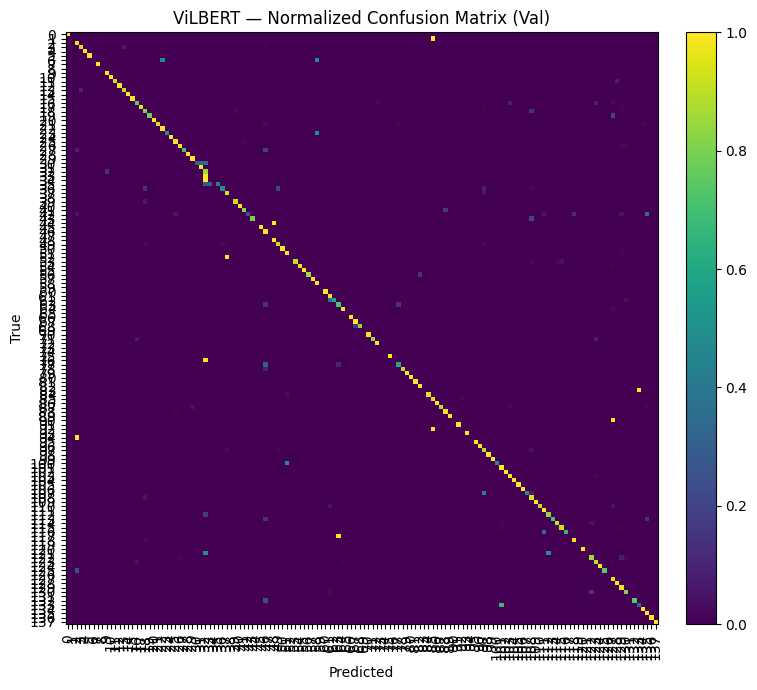

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, class_names=None, normalize=True, title="Confusion Matrix", max_classes=50):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names) if class_names else np.max(y_true)+1))
    if normalize:
        cm = cm.astype(np.float64)
        row_sums = cm.sum(axis=1, keepdims=True) + 1e-12
        cm = cm / row_sums

    # Optionally truncate to the most frequent classes to keep it legible
    if class_names and len(class_names) > max_classes:
        # show top-N frequent classes in y_true
        counts = np.bincount(y_true, minlength=len(class_names))
        top_idx = np.argsort(-counts)[:max_classes]
        cm = cm[top_idx][:, top_idx]
        shown_names = [class_names[i] for i in top_idx]
    else:
        shown_names = class_names

    plt.figure(figsize=(8, 7))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar(fraction=0.046, pad=0.04)
    ticks = np.arange(len(shown_names)) if shown_names else np.arange(cm.shape[0])
    plt.xticks(ticks, shown_names, rotation=90)
    plt.yticks(ticks, shown_names)
    plt.tight_layout()
    plt.show()

class_names = getattr(dm, "class_names", None)
plot_confusion(vil_val["y_true"], vil_val["y_pred"], class_names=class_names, normalize=True,
               title="ViLBERT — Normalized Confusion Matrix (Val)")

ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


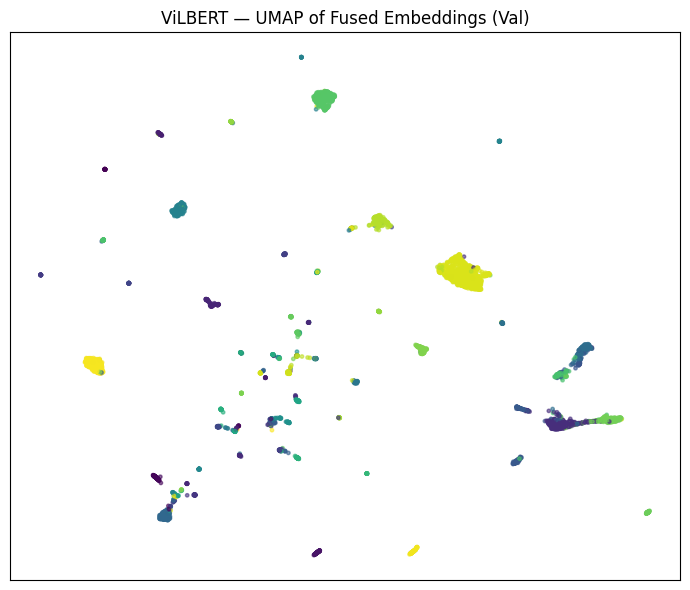

ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


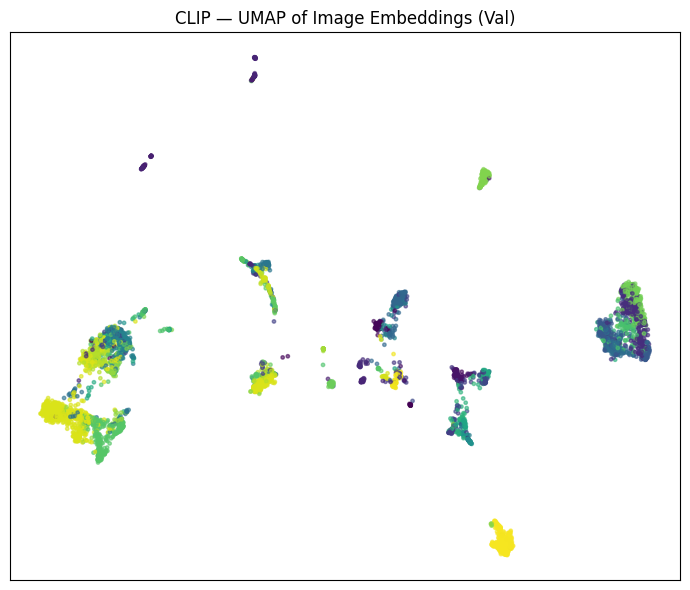

In [79]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# optionally handle scipy sparse inputs
try:
    import scipy.sparse as sp
except Exception:
    sp = None

def umap_scatter(X, y, title, n_neighbors=30, min_dist=0.1, metric="cosine", max_points=5000, alpha=0.6):
    rng = np.random.default_rng(42)
    if X.shape[0] > max_points:
        idx = rng.choice(X.shape[0], size=max_points, replace=False)
        X, y = X[idx], y[idx]
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=42)
    Z = reducer.fit_transform(X)
    plt.figure(figsize=(7,6))
    plt.scatter(Z[:,0], Z[:,1], s=6, c=y, alpha=alpha)
    plt.title(title)
    plt.xticks([]); plt.yticks([]); plt.tight_layout(); plt.show()
    return Z

# Resolve ViLBERT fused features (try known variable names in the notebook)
if 'Z' in globals():
    X_vil = Z
elif 'embeddings_late' in globals():
    X_vil = embeddings_late
else:
    raise NameError("ViLBERT fused features not found. Ensure `Z` or `embeddings_late` is defined in the notebook.")

# Resolve ViLBERT labels (use vil_val if available)
if 'vil_val' in globals() and isinstance(vil_val, dict) and 'y_true' in vil_val:
    y_vil = np.asarray(vil_val["y_true"])
elif 'y_val' in globals():
    # y_val may be a torch tensor
    try:
        y_vil = y_val.detach().cpu().numpy()
    except Exception:
        y_vil = np.asarray(y_val)
else:
    raise NameError("ViLBERT labels not found. Ensure `vil_val['y_true']` or `y_val` is defined.")

# Robust conversion of X_vil to a dense numpy array:
def to_numpy_dense(x):
    # torch tensor
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
    except Exception:
        pass

    # scipy sparse
    if sp is not None and sp.issparse(x):
        return x.toarray()

    # objects exposing toarray (e.g., some sparse types)
    if hasattr(x, "toarray"):
        try:
            return x.toarray()
        except Exception:
            pass

    # pandas DataFrame
    if hasattr(x, "values"):
        try:
            return np.asarray(x.values)
        except Exception:
            pass

    # fallback
    return np.asarray(x)

X_vil = to_numpy_dense(X_vil)
y_vil = np.asarray(y_vil)

Z_vil = umap_scatter(X_vil, y_vil, "ViLBERT — UMAP of Fused Embeddings (Val)")

# Resolve CLIP image embeddings and labels (img_val, y_val)
if 'img_val' in globals():
    X_clip_img = to_numpy_dense(img_val)
else:
    raise NameError("CLIP image embeddings `img_val` not found. Ensure `img_val` is defined.")

if 'y_val' in globals():
    try:
        y_clip = y_val.detach().cpu().numpy()
    except Exception:
        y_clip = np.asarray(y_val)
else:
    raise NameError("CLIP labels `y_val` not found. Ensure `y_val` is defined.")

Z_clip = umap_scatter(X_clip_img, y_clip, "CLIP — UMAP of Image Embeddings (Val)")

1. 2 multimodal strategies were evaluated:
* CLIP (dual-encoder): contrastive model that aligns text and image by pulling matched pairs together and pushing non-matches apart. It is naturally judged by cross-modal retrieval (Text→Image / Image→Text) and alignment quality, while classification requires either a prototype head or a small probe.
* ViLBERT-style cross-attention classifier: supervised model that fuses text tokens with a projected image embedding via cross-attention, then predicts a single class with softmax. It's judged by Top-1 accuracy, Macro-F1, per-class and bucketed (head/mid/tail) performance.
* Both models are interpreted using normalized confusion matrices (error structure) and UMAP projections.


2. Models:
* CLIP (Dual-Encoder) optimizes a shared semantic space, produces smooth neighborhoods where visually/semantically similar items lie near each other, even if they belong to different fine-grained labels. It's ideal for retrieval but it doesn't enforce hard class boundaries.
* ViLBERT (Cross-Attention Classifier) optimizes class separation. Supervised training + cross-attention pushes examples from the same label into compact clusters and increases boundaries between classes. 


3. Confusion Matrix (ViLBERT, rows are true classes columns are predicted). Row-normalization makes each row sum to 1.0, so the color of a cell shows the fraction of true class routed to predicted class. It shows a strong diagonal with only a few small off-diagonal errors, indicating good overall discrimination. The remaining errors mostly occur between visually similar classes, particularly those in the long tail.


4. UMAPs:
* CLIP: UMAP of Image Embeddings (Val): some broad clusters + "bridges" (i.e., those represent shared visual attributes across labels: fabric, cut,l length etc) between them. within each, colors (class ids) intermix smoothly. Conclusion: broad semantic neighborhoods with soft boundaries, ideal for retrieval and zero-shot transfer, yet not designed to enforce fine-grained class separation.
* ViLBERT: UMAP of Fused Embeddings (Val): many compact, well-separated clusters with fewer bridges, clusters here appear tighter than in CLIP. Conclusion: compact, class-specific clusters with clear boundaries, reflecting supervised separation that supports high Top-1 and Macro-F1.

Conclusion: CLIP learns trustable alignment as its embedding space forms broad, semantically meaningful neighborhoods that deliver strong cross-modal retrieval. Meanwhile, ViLBERT enforces fine-grained separation. Altogether they are complementary. 

## 4. MVAE

In [ ]:
import os
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)

from comparative.datasets.fashion_datamodule import FashionDatamodule
from comparative.models.vae.hybrid_module import HybridVAEClassifier

# PROJECT_ROOT = "D:/COmparative_Study_of_Multimodal_Represenations"
# os.environ["PROJECT_ROOT"] = PROJECT_ROOT

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CKPT_HYB_FASHION = CHECKPOINTS / "default" / "fashion_hybrid" / "last.ckpt"

# CKPT_HYB_FASHION = (
#     "D:/COmparative_Study_of_Multimodal_Represenations/"
#     "src/comparative/checkpoints/default/fashion_hybrid/last.ckpt"
# )
print("Checkpoint:", CKPT_HYB_FASHION)

dm_hyb = FashionDatamodule(
    data_dir= DATA_PROCESSED / "fashion",
    tokenizer_name="distilbert-base-uncased",
    batch_size=64,
    max_len=128,
    img_size=224,
    num_workers=8,
    train_samples=None,
    val_samples=None,
)

dm_hyb.setup()
val_loader_h  = dm_hyb.val_dataloader()
test_loader_h = dm_hyb.test_dataloader()

print("VAL batches:", len(val_loader_h))
print("TEST batches:", len(test_loader_h))

# --- Load model ---
hyb_fashion = HybridVAEClassifier.load_from_checkpoint(
    CKPT_HYB_FASHION,
    map_location=DEVICE,
)
hyb_fashion = hyb_fashion.to(DEVICE)
hyb_fashion.eval()

print("num_labels:", getattr(hyb_fashion, "num_labels", None))
print("multilabel:", getattr(hyb_fashion, "multilabel", None))


train size: 31992 classes: 138
val size:   8889
VAL batches: 139
TEST batches: 56
num_labels: None
multilabel: None


In [ ]:
# helper: collect logits & labels for mvae
from torch.utils.data import DataLoader
from torch import nn

def collect_logits_and_labels_hfashion(model, loader, max_batches=None):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for b_idx, batch in enumerate(loader):
            # Move only tensors to device
            model_inputs = {}
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    model_inputs[k] = v.to(DEVICE)
                else:
                    model_inputs[k] = v

            labels = model_inputs.get("labels")
            if labels is None:
                # some datamodules might use 'label' instead
                labels = model_inputs.get("label")
            if labels is None:
                raise RuntimeError("No 'labels' or 'label' key found in batch!")

            # Forward: HybridVAEClassifier may return (logits, mu, logvar)
            outputs = model(model_inputs)
            if isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            all_logits.append(logits.detach().cpu())
            all_labels.append(labels.detach().cpu())

            if (max_batches is not None) and (b_idx + 1 >= max_batches):
                break

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_logits, all_labels

In [ ]:
def eval_hybrid_fashion_split(name, loader):
    logits, labels = collect_logits_and_labels_hfashion(hyb_fashion, loader)
    # logits: (N, C), labels: (N,)
    y_true = labels.numpy().astype(int)
    y_pred = logits.argmax(dim=1).numpy().astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    print(f"\nHybrid VAE (fashion) — {name} metrics")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1       : {f1:.4f}")

    return {
        "logits": logits,
        "labels": labels,
        "y_true": y_true,
        "y_pred": y_pred,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
    }

hyb_fashion_val  = eval_hybrid_fashion_split("VAL",  val_loader_h)
hyb_fashion_test = eval_hybrid_fashion_split("TEST", test_loader_h)


Hybrid VAE (FashionAI) — VAL metrics
  Accuracy : 0.8655
  Precision: 0.6186
  Recall   : 0.5700
  F1       : 0.5785

Hybrid VAE (FashionAI) — TEST metrics
  Accuracy : 0.8689
  Precision: 0.6858
  Recall   : 0.6662
  F1       : 0.6638


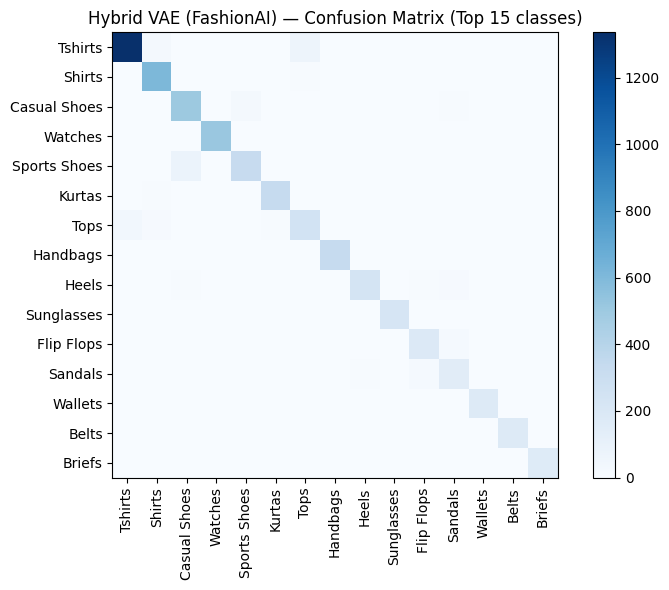

In [ ]:
#confusion matrix for the top-K most frequent classes
K = 15  # ex: 15 classes

label2idx = getattr(dm_hyb, "label2idx", None)
if label2idx is not None:
    idx2label = {v: k for k, v in label2idx.items()}
else:
    idx2label = {i: f"class_{i}" for i in range(int(hyb_fashion_val["y_true"].max()) + 1)}

y_true_val = hyb_fashion_val["y_true"]
class_counts = np.bincount(y_true_val)
head_idx = np.argsort(class_counts)[::-1][:K]

cm = confusion_matrix(y_true_val, hyb_fashion_val["y_pred"], labels=head_idx)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title(f"Hybrid VAE (fashion) — Confusion Matrix (Top {K} classes)")
plt.colorbar()
tick_labels = [idx2label[i] for i in head_idx]
plt.xticks(range(K), tick_labels, rotation=90)
plt.yticks(range(K), tick_labels)
plt.tight_layout()
plt.show()

Overall, MVAE achieves solid mid-tier performance, given the dataset's imbalance, multimodal setting and fine-grained categories. In confusion matrix we see that there is strong diagonal across major classes (Tshirts, Shirts, Watches, Casual Shoes, Sports Shoes), with most misclassifications occurring among visually similar subcategories.

Conclusion: MVAE achieves competitive top-1 accuracy (~0.87) and moderate macro-F1 (~0.66), yet doesn't outperform CLIP and ViLBERT. Although MVAE provides well-structured latent representations and reasonable classification strength, it's not architecturally optimized for maximum top-1 discriminative accuracy.


#### Semantic analysis

In [ ]:
# Collect latent z, logits, and labels on VAL


from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

if hasattr(dm_hyb, "idx2label"):
    id2label = dm_hyb.idx2label
elif hasattr(dm_hyb, "label_encoder"):
    id2label = list(dm_hyb.label_encoder.classes_)
else:
    # fallback: numeric labels only
    n_classes = getattr(dm_hyb, "num_classes", None)
    if n_classes is None:
        # infer from a single batch
        batch0 = next(iter(val_loader_h))
        n_classes = int(batch0["label"].max().item()) + 1
    id2label = [f"class_{i}" for i in range(n_classes)]

num_classes = len(id2label)
print("num_classes:", num_classes)

DEVICE: cuda
num_classes: 138


In [ ]:
# Find the first Linear layer inside the classifier / head to hook
target_linear = None
for name, m in hyb_fashion.named_modules():
    if isinstance(m, torch.nn.Linear):
        target_linear = m
        print("Hooking layer:", name, "->", m)
        break

if target_linear is None:
    raise RuntimeError("Cant find a Linear layer in MVAE model to hook")

latent_chunks = []
label_chunks = []

def hook_fn(module, inp, out):
    x = inp[0]
    # sanity: ensure 2D (B, D)
    if x.ndim > 2:
        x = x.view(x.size(0), -1)
    latent_chunks.append(x.detach().cpu())

hook_handle = target_linear.register_forward_hook(hook_fn)

# --- Pass VAL set once to populate latent_chunks + labels ---
hyb_fashion.eval()
with torch.no_grad():
    for batch in tqdm(val_loader_h, desc="Collecting MVAE latent features (VAL)"):
        # move tensors to device
        batch_on_device = {
            k: (v.to(DEVICE) if isinstance(v, torch.Tensor) else v)
            for k, v in batch.items()
        }
        labels = batch_on_device.get("label", batch_on_device.get("labels"))
        if labels is None:
            raise RuntimeError("Expected 'label' or 'labels' in fashion batch.")
        label_chunks.append(labels.detach().cpu())

        out = hyb_fashion(batch_on_device)
        # forward may return logits or (logits, aux); we only need to run it
        if isinstance(out, tuple):
            _ = out[0]
        else:
            _ = out

hook_handle.remove()

Z_val = torch.cat(latent_chunks, dim=0).numpy()       # (N, D_latent)
y_val = torch.cat(label_chunks, dim=0).numpy().astype(int)  # (N,)

print("Z_val shape:", Z_val.shape)
print("y_val shape:", y_val.shape)

Hooking layer: text_encoder.transformer.layer.0.attention.q_lin -> Linear(in_features=768, out_features=768, bias=True)


Z_val shape: (8889, 98304)
y_val shape: (8889,)


ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


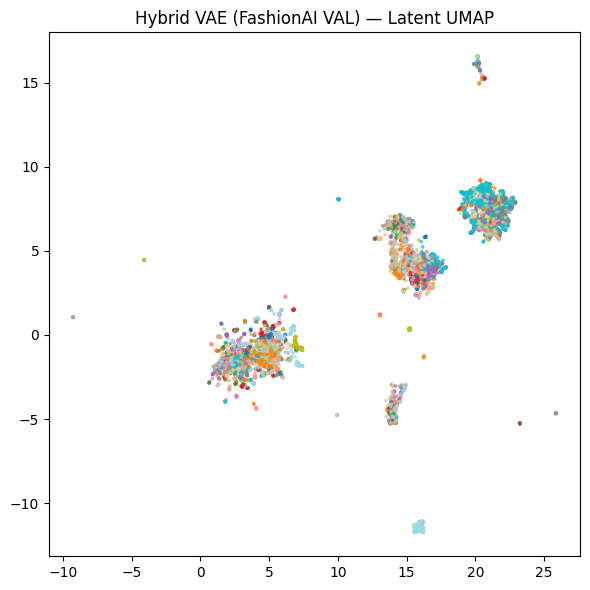

Silhouette (cosine): -0.3353081941604614
Mean kNN agreement@15: 0.4145273184085199
Median kNN agreement@15: 0.3333333333333333


In [ ]:
# UMAP to 2D
u = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
Z2 = u.fit_transform(Z_val)

plt.figure(figsize=(6, 6))
plt.scatter(Z2[:, 0], Z2[:, 1], c=y_val, s=3, alpha=0.6, cmap="tab20")
plt.title("MVAE (VAL) - Latent UMAP")
plt.tight_layout()
plt.show()

# Silhouette on latent space (single-label)
from sklearn.preprocessing import StandardScaler

Z_std = StandardScaler(with_mean=False).fit_transform(Z_val)
sil = silhouette_score(Z_std, y_val, metric="cosine")

# kNN label agreement@15
nbrs = NearestNeighbors(n_neighbors=15, metric="cosine").fit(Z_val)
_, idx = nbrs.kneighbors(Z_val)

agree = [(y_val[i] == y_val[idx[i]]).mean() for i in range(len(y_val))]
print("Silhouette (cosine):", float(sil))
print("Mean kNN agreement@15:", float(np.mean(agree)))
print("Median kNN agreement@15:", float(np.median(agree)))

In [ ]:
# Cluster in latent space (unsupervised) and compare to true labels
K = num_classes   # can choose smaller K for efficiency
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_ids = kmeans.fit_predict(Z_val)

nmi = normalized_mutual_info_score(y_val, cluster_ids)
ari = adjusted_rand_score(y_val, cluster_ids)

print("Clustering on MVAE latent space (VAL):")
print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")

Clustering on MVAE latent space (VAL):
NMI: 0.2211
ARI: 0.0318


In [ ]:
# Compute class centroids in latent space
centroids = np.zeros((num_classes, Z_val.shape[1]), dtype=np.float32)
counts = np.zeros(num_classes, dtype=np.int64)

for z, label in zip(Z_val, y_val):
    centroids[label] += z
    counts[label] += 1

# avoid division by zero
valid = counts > 0
centroids[valid] /= counts[valid, None]

print("Number of classes with at least one VAL example:", valid.sum())

# kNN over centroids: which classes are nearest to each class?
cent_nbrs = NearestNeighbors(n_neighbors=6, metric="cosine").fit(centroids[valid])
_, cent_idx = cent_nbrs.kneighbors(centroids[valid])

# print neighbors for first 10 popular classes
print("\nNearest centroid neighbors (cosine) for a few classes:")
for j, c_idx in enumerate(np.where(valid)[0][:10]):
    neighbors = cent_idx[j][1:]   # skip self (index 0)
    neigh_names = [id2label[valid.nonzero()[0][k]] for k in neighbors]
    print(f"  {id2label[c_idx]} -> {', '.join(neigh_names)}")

Number of classes with at least one VAL example: 127

Nearest centroid neighbors (cosine) for a few classes:
  class_0 -> class_108, class_18, class_97, class_122, class_39
  class_1 -> class_85, class_70, class_58, class_22, class_87
  class_2 -> class_18, class_46, class_97, class_134, class_108
  class_3 -> class_88, class_21, class_17, class_49, class_36
  class_4 -> class_18, class_37, class_97, class_2, class_108
  class_5 -> class_85, class_36, class_70, class_87, class_50
  class_6 -> class_70, class_58, class_81, class_98, class_87
  class_7 -> class_37, class_49, class_46, class_134, class_18
  class_9 -> class_70, class_50, class_40, class_85, class_36
  class_10 -> class_43, class_97, class_134, class_2, class_49


In [ ]:
#Latent interpolation using a linear probe on Z_val 

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. fit a simple linear probe on mvae latent space
probe = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(
        multi_class="multinomial",
        max_iter=200,
        n_jobs=-1,
        verbose=0,
    ),
)

print("Fitting linear probe on mvae latent Z (VAL)...")
probe.fit(Z_val, y_val)
print("Probe fitted.")

def softmax_np(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=-1, keepdims=True)

def interpolate_and_inspect_latent(i, j, alphas=None, top_k=5):
    """
    Interpolate between two VAL samples i and j in mvae latent space (Z_val),
    and inspect predicted class distribution using a linear probe.
    """
    if alphas is None:
        alphas = np.linspace(0.0, 1.0, 7)

    z_i = Z_val[i]
    z_j = Z_val[j]

    print(f"Interpolate from idx {i} (label={id2label[y_val[i]]}) "
          f"to idx {j} (label={id2label[y_val[j]]})")

    for a in alphas:
        z = (1.0 - a) * z_i + a * z_j   # (D_latent,)
        # probe.decision_function returns class logits
        logits = probe.decision_function(z.reshape(1, -1))  # (1, C)
        probs = softmax_np(logits)[0]                       # (C,)

        top_idx = probs.argsort()[::-1][:top_k]
        top_pairs = [(id2label[k], float(probs[k])) for k in top_idx]

        print(f"\nalpha={a:.2f}")
        for name, p in top_pairs:
            print(f"  {name:25s} : {p:.3f}")

# ex: pick two indices from VAL
interpolate_and_inspect_latent(0, 100)

Fitting linear probe on Hybrid latent Z (VAL)...


ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Probe fitted.
Interpolate from idx 0 (label=class_54) to idx 100 (label=class_129)

alpha=0.00
  class_44                  : 0.086
  class_124                 : 0.050
  class_46                  : 0.044
  class_119                 : 0.042
  class_17                  : 0.041

alpha=0.17
  class_44                  : 0.068
  class_119                 : 0.066
  class_124                 : 0.048
  class_46                  : 0.041
  class_17                  : 0.038

alpha=0.33
  class_119                 : 0.103
  class_44                  : 0.053
  class_124                 : 0.045
  class_46                  : 0.036
  class_17                  : 0.035

alpha=0.50
  class_119                 : 0.155
  class_124                 : 0.041
  class_44                  : 0.039
  class_57                  : 0.033
  class_46                  : 0.031

alpha=0.67
  class_119                 : 0.224
  class_124                 : 0.036
  class_57                  : 0.032
  class_44                  :

In [ ]:
# Example: define a "footwear" vs "non-footwear" attribute direction
footwear_keywords = ["Shoes", "Sandals", "Heels", "Flip Flops", "Sneakers", "Sports Shoes"]

footwear_ids = [i for i, name in enumerate(id2label) if any(k.lower() in name.lower() for k in footwear_keywords)]
non_foot_ids = [i for i in range(num_classes) if i not in footwear_ids]

print("Footwear ids:", footwear_ids)
print("Non-footwear ids:", non_foot_ids[:10], "...")

if footwear_ids and non_foot_ids:
    # centroid over footwear classes vs non-footwear
    z_foot = centroids[footwear_ids].mean(axis=0)
    z_non  = centroids[non_foot_ids].mean(axis=0)

    direction = z_foot - z_non
    # normalize
    direction = direction / (np.linalg.norm(direction) + 1e-8)

    # project all VAL points on this direction
    proj = Z_val @ direction

    plt.figure(figsize=(6,4))
    plt.hist(proj[[lbl in footwear_ids for lbl in y_val]], bins=40, alpha=0.7, label="Footwear")
    plt.hist(proj[[lbl not in footwear_ids for lbl in y_val]], bins=40, alpha=0.7, label="Others")
    plt.xlabel("Projection on footwear direction")
    plt.ylabel("Count")
    plt.title("MVAE latent projection: footwear vs others")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Cant find footwear class names -> adjust `footwear_keywords`.")

Footwear ids: []
Non-footwear ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ...
Could not find footwear class names; adjust `footwear_keywords`.


MVAE's latent space on the validation split (8 889 images, 138 classes) was analyzed to get a better understanding of what MVAE learns on this dataset. It was done using UMAP, k-nearest neighbours, clustering metrics, and simple linear probes.

Results:
* The MVAE learns a meaningfully structured latent space, where examples naturally form broad fashion clusters, and nearby points often share meaningful label similarities.
* Global clustering metrics (NMI/ARI) and the UMAP plot highlight the difficulty of perfectly separating 138 highly overlapping categories, but still confirm that the space is far from random.